In [ ]:
!pip install --upgrade --force-reinstall "qiskit-algorithms>=0.5.0"




ERROR: Could not find a version that satisfies the requirement qiskit-algorithms>=0.5.0 (from versions: 0.1.0, 0.2.0, 0.2.1, 0.2.2, 0.3.0, 0.3.1, 0.4.0)
ERROR: No matching distribution found for qiskit-algorithms>=0.5.0


In [ ]:
# ======================================
# 0) 安装依赖
# ======================================
!pip install qiskit qiskit-aer transformers torch scikit-learn -q

import numpy as np
import torch
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit_aer import Aer
from qiskit.quantum_info import Statevector
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from torch import nn

# ======================================
# 1) 定义线性系统 Ax = b
#    示例：A = [[1,1],[1,3]], b = [1,0]
# ======================================
A = np.array([[1, 1],
              [1, 3]])
b = np.array([1, 0]) / np.linalg.norm([1, 0])  # 归一化

# ======================================
# 2) 定义 VQLS ansatz 电路
# ======================================
theta1, theta2 = Parameter("θ1"), Parameter("θ2")

def create_ansatz():
    qc = QuantumCircuit(2)
    qc.ry(theta1, 0)
    qc.cx(0, 1)
    qc.ry(theta2, 1)
    return qc

# ======================================
# 3) 计算残差函数 C(θ)
# ======================================
def compute_residual(params):
    qc = create_ansatz()
    qc_bound = qc.assign_parameters({theta1: params[0], theta2: params[1]}, inplace=False)

    backend = Aer.get_backend("statevector_simulator")
    job = backend.run(transpile(qc_bound, backend))
    state = job.result().get_statevector(qc_bound)

    # ✅ 转成 numpy array 再取前 2 维
    state = np.array(state)

    Ax = A @ state[:2]   # 取前 2 维（对应 2 qubits）
    diff = Ax - b
    return np.real(np.vdot(diff, diff))

# ======================================
# 4) 电路转语言 (Quantum2Prompt)
# ======================================
def circuit_to_text(circ: QuantumCircuit):
    desc = []
    for instr, qargs, _ in circ.data:
        name = instr.name.upper()
        # ✅ 获取 qubit 的编号
        q_indices = [circ.find_bit(q).index for q in qargs]

        if name in ["RY", "RX", "RZ"]:
            desc.append(f"Apply {name} with parameter on qubit {q_indices[0]}.")
        elif name == "CX":
            desc.append(f"Apply CNOT with control qubit {q_indices[0]} and target qubit {q_indices[1]}.")
        else:
            desc.append(f"Apply {name} gate on qubit(s) {q_indices}.")
    return " ".join(desc)

# ======================================
# 5) 构造数据集 (文本 + 残差)
# ======================================
def generate_dataset(n=200):
    X, y = [], []
    for _ in range(n):
        params = np.random.uniform(0, 2*np.pi, 2)
        qc = create_ansatz().assign_parameters({theta1: params[0], theta2: params[1]}, inplace=False)
        text = circuit_to_text(qc)
        res = compute_residual(params)
        X.append(text)
        y.append(res)
    return X, np.array(y)

X, y = generate_dataset(200)

# ======================================
# 6) BERT 向量化
# ======================================
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert = AutoModel.from_pretrained("bert-base-uncased").to(device)

def encode_batch(texts):
    enc = tokenizer(texts, padding=True, truncation=True, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = bert(**enc).last_hidden_state.mean(dim=1)
    return outputs.cpu().numpy()

X_embed = encode_batch(X)

# ======================================
# 7) 训练回归模型
# ======================================
X_train, X_test, y_train, y_test = train_test_split(X_embed, y, test_size=0.2)

model = nn.Sequential(
    nn.Linear(X_train.shape[1], 128),
    nn.ReLU(),
    nn.Linear(128, 1)
).to(device)

loss_fn = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)
X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_t = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(device)

for epoch in range(30):
    model.train()
    pred = model(X_train_t)
    loss = loss_fn(pred, y_train_t)
    opt.zero_grad()
    loss.backward()
    opt.step()
    if epoch % 5 == 0:
        print(f"Epoch {epoch}: train loss = {loss.item():.4f}")

# ======================================
# 8) 评估
# ======================================
model.eval()
with torch.no_grad():
    y_pred = model(X_test_t).cpu().numpy().flatten()

print("MSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 53.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 1.7 MB/s eta 0:00:00


/tmp/ipython-input-3885886226.py:60: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, _ in circ.data:
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 0: train loss = 33.3866
Epoch 5: train loss = 18.8610
Epoch 10: train loss = 12.6303
Epoch 15: train loss = 13.4523
Epoch 20: train loss = 13.7602
Epoch 25: train loss = 12.5568
MSE: 10.313510857634705
R²: -0.001003680367760662


In [ ]:
# ======================================
# 0) 安装依赖 (Qiskit 稳定组合)
# ======================================
!pip install qiskit==0.43.2 qiskit-aer==0.12.0 qiskit-optimization==0.6.0 transformers torch scikit-learn -q

import numpy as np
import torch
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit_aer import Aer
from qiskit.quantum_info import Statevector
from qiskit.algorithms.optimizers import COBYLA   # ✅ 老版本可用
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from torch import nn

# ======================================
# 1) 定义线性系统 Ax = b
# ======================================
A = np.array([[1, 1],
              [1, 3]])
b = np.array([1, 0]) / np.linalg.norm([1, 0])  # 归一化

# ======================================
# 2) 定义 VQLS ansatz 电路
# ======================================
theta1, theta2 = Parameter("θ1"), Parameter("θ2")

def create_ansatz():
    qc = QuantumCircuit(2)
    qc.ry(theta1, 0)
    qc.cx(0, 1)
    qc.ry(theta2, 1)
    return qc

# ======================================
# 3) 残差函数 C(θ)
# ======================================
def compute_residual(params):
    qc = create_ansatz()
    qc_bound = qc.assign_parameters({theta1: params[0], theta2: params[1]}, inplace=False)

    backend = Aer.get_backend("statevector_simulator")
    job = backend.run(transpile(qc_bound, backend))
    state = job.result().get_statevector(qc_bound)

    state = np.array(state)
    Ax = A @ state[:2]   # 取前 2 维
    diff = Ax - b
    return np.real(np.vdot(diff, diff))

# ======================================
# 4) 电路转文本 (带参数)
# ======================================
def circuit_to_text(circ: QuantumCircuit, params=None):
    desc = []
    param_list = params.copy() if params is not None else []
    for instr, qargs, _ in circ.data:
        name = instr.name.upper()
        q_indices = [circ.find_bit(q).index for q in qargs]

        if name in ["RY", "RX", "RZ"]:
            if param_list:
                val = param_list.pop(0)
                desc.append(f"Apply {name} with parameter {val:.4f} on qubit {q_indices[0]}.")
            else:
                desc.append(f"Apply {name} with parameter on qubit {q_indices[0]}.")
        elif name == "CX":
            desc.append(f"Apply CNOT with control qubit {q_indices[0]} and target qubit {q_indices[1]}.")
        else:
            desc.append(f"Apply {name} gate on qubit(s) {q_indices}.")
    return " ".join(desc)

# ======================================
# 5) 优化器收集真实轨迹
# ======================================
def objective(params):
    return compute_residual(params)

def run_vqls_optimization(maxiter=50, initial_point=None):
    optimizer = COBYLA(maxiter=maxiter, tol=1e-6)
    history = []

    def callback(xk):
        res = compute_residual(xk)
        qc = create_ansatz().assign_parameters({theta1: xk[0], theta2: xk[1]}, inplace=False)
        text = circuit_to_text(qc, params=list(xk))
        history.append((text, res))

    if initial_point is None:
        initial_point = np.random.uniform(0, 2*np.pi, 2)

    optimizer.minimize(fun=objective, x0=initial_point, callback=callback)
    return history

def generate_real_dataset(runs=20, steps=50):
    X, y = [], []
    for _ in range(runs):
        traj = run_vqls_optimization(maxiter=steps)
        for text, res in traj:
            X.append(text)
            y.append(res)
    return X, np.array(y)

X, y = generate_real_dataset(runs=20, steps=50)
print(f"✅ 数据集规模: {len(X)} 条样本")
print("示例：", X[0], " -> ", y[0])

# ======================================
# 6) BERT 向量化
# ======================================
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert = AutoModel.from_pretrained("bert-base-uncased").to(device)

def encode_batch(texts):
    enc = tokenizer(texts, padding=True, truncation=True, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = bert(**enc).last_hidden_state.mean(dim=1)
    return outputs.cpu().numpy()

X_embed = encode_batch(X)

# ======================================
# 7) 训练回归模型 (MLP)
# ======================================
X_train, X_test, y_train, y_test = train_test_split(X_embed, y, test_size=0.2, random_state=42)

model = nn.Sequential(
    nn.Linear(X_train.shape[1], 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 1)
).to(device)

loss_fn = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)
X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_t = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(device)

for epoch in range(30):
    model.train()
    pred = model(X_train_t)
    loss = loss_fn(pred, y_train_t)
    opt.zero_grad()
    loss.backward()
    opt.step()
    if epoch % 5 == 0:
        print(f"Epoch {epoch}: train loss = {loss.item():.4f}")

# ======================================
# 8) 评估
# ======================================
model.eval()
with torch.no_grad():
    y_pred = model(X_test_t).cpu().numpy().flatten()

print("MSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 58.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 72.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
ERROR: Cannot install qiskit-aer==0.12.0 and qiskit==0.43.2 because these package versions have conflicting dependencies.
ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts


ModuleNotFoundError: No module named 'qiskit.primitives.primitive_job'

In [ ]:
!pip uninstall -y qiskit qiskit-aer qiskit-terra qiskit-optimization qiskit-algorithms
!pip install qiskit==0.39.4 qiskit-aer==0.11.2 qiskit-optimization==0.5.0 transformers torch scikit-learn -q


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 13.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [ ]:
# ======================================
# 改进版：BERT + 深层MLP 回归 VQLS 残差
# ======================================
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from torch import nn

# ======================================
# 1) 扩充数据集
# ======================================
X, y = generate_real_dataset(runs=100, steps=50)  # ~5000 样本
print(f"✅ 数据集规模: {len(X)} 条样本")

# ======================================
# 2) BERT 向量化
# ======================================
X_embed = encode_batch(X)

# ======================================
# 3) 目标值归一化
# ======================================
y_mean, y_std = y.mean(), y.std()
y_norm = (y - y_mean) / y_std

X_train, X_test, y_train, y_test = train_test_split(X_embed, y_norm, test_size=0.2, random_state=42)

# ======================================
# 4) 深层 MLP 模型
# ======================================
device = "cuda" if torch.cuda.is_available() else "cpu"

model = nn.Sequential(
    nn.Linear(X_train.shape[1], 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 1)
).to(device)

loss_fn = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)
X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_t = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(device)

# ======================================
# 5) 训练 100 epoch
# ======================================
for epoch in range(100):
    model.train()
    pred = model(X_train_t)
    loss = loss_fn(pred, y_train_t)
    opt.zero_grad()
    loss.backward()
    opt.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: train loss = {loss.item():.4f}")

# ======================================
# 6) 评估
# ======================================
model.eval()
with torch.no_grad():
    y_pred_norm = model(X_test_t).cpu().numpy().flatten()

# 反归一化
y_pred = y_pred_norm * y_std + y_mean
y_test_true = y_test * y_std + y_mean

print("MSE:", mean_squared_error(y_test_true, y_pred))
print("R²:", r2_score(y_test_true, y_pred))



/tmp/ipython-input-485794403.py:59: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, _ in circ.data:


✅ 数据集规模: 4117 条样本
Epoch 0: train loss = 0.9224
Epoch 10: train loss = 0.9126
Epoch 20: train loss = 0.8539
Epoch 30: train loss = 0.7807
Epoch 40: train loss = 0.7232
Epoch 50: train loss = 0.6929
Epoch 60: train loss = 0.6687
Epoch 70: train loss = 0.6543
Epoch 80: train loss = 0.6463
Epoch 90: train loss = 0.6566
MSE: 0.2730702671591361
R²: 0.22099697901703663


/tmp/ipython-input-2805078210.py:63: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, _ in circ.data:


✅ 数据集规模: 1163 条样本
示例： Apply RY with parameter 2.2619 on qubit 0. Apply CNOT with control qubit 0 and target qubit 1. Apply RY with parameter 7.1502 on qubit 1.  ->  1.5809942379338673
✅ 向量化完成: (1163, 768)
Epoch 0: avg train loss = 1.0306, lr=0.001000
Epoch 10: avg train loss = 0.7511, lr=0.001000
Epoch 20: avg train loss = 0.6528, lr=0.001000
Epoch 30: avg train loss = 0.6468, lr=0.001000
Epoch 40: avg train loss = 0.5840, lr=0.001000
Epoch 50: avg train loss = 0.5096, lr=0.000500
Epoch 60: avg train loss = 0.4790, lr=0.000500
Epoch 70: avg train loss = 0.4645, lr=0.000500
Epoch 80: avg train loss = 0.5483, lr=0.000500
Epoch 90: avg train loss = 0.3910, lr=0.000500
Epoch 100: avg train loss = 0.2944, lr=0.000250
Epoch 110: avg train loss = 0.3076, lr=0.000250
Epoch 120: avg train loss = 0.2539, lr=0.000250
Epoch 130: avg train loss = 0.2372, lr=0.000250
Epoch 140: avg train loss = 0.2609, lr=0.000250
Epoch 150: avg train loss = 0.2011, lr=0.000125
Epoch 160: avg train loss = 0.1661, lr

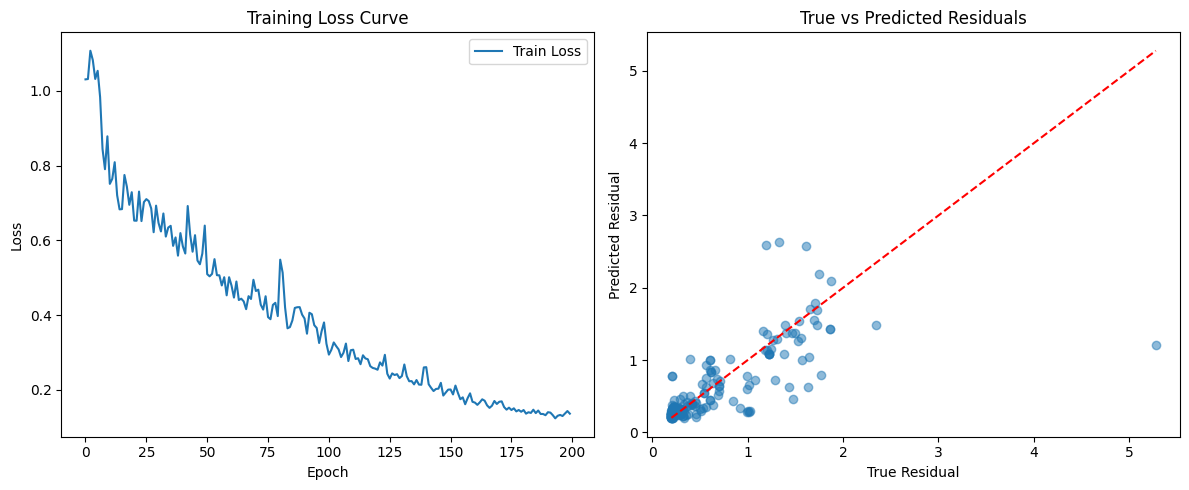

In [ ]:
# ======================================
# 0) 安装依赖
# ======================================
!pip install qiskit qiskit-aer transformers torch scikit-learn scipy matplotlib -q

import numpy as np
import torch
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit_aer import Aer
from qiskit.quantum_info import Statevector
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import gc

# ======================================
# 1) 定义线性系统 Ax = b
# ======================================
A = np.array([[1, 1],
              [1, 3]])
b = np.array([1, 0]) / np.linalg.norm([1, 0])  # 归一化

# ======================================
# 2) 定义 VQLS ansatz 电路
# ======================================
theta1, theta2 = Parameter("θ1"), Parameter("θ2")

def create_ansatz():
    qc = QuantumCircuit(2)
    qc.ry(theta1, 0)
    qc.cx(0, 1)
    qc.ry(theta2, 1)
    return qc

# ======================================
# 3) 残差函数 C(θ)
# ======================================
def compute_residual(params):
    qc = create_ansatz()
    qc_bound = qc.assign_parameters({theta1: params[0], theta2: params[1]}, inplace=False)

    backend = Aer.get_backend("statevector_simulator")
    job = backend.run(transpile(qc_bound, backend))
    state = job.result().get_statevector(qc_bound)

    state = np.array(state)
    Ax = A @ state[:2]   # 取前 2 维
    diff = Ax - b
    return np.real(np.vdot(diff, diff))

# ======================================
# 4) 电路转文本 (带参数)
# ======================================
def circuit_to_text(circ: QuantumCircuit, params=None):
    desc = []
    param_list = params.copy() if params is not None else []
    for instr, qargs, _ in circ.data:
        name = instr.name.upper()
        q_indices = [circ.find_bit(q).index for q in qargs]

        if name in ["RY", "RX", "RZ"]:
            if param_list:
                val = param_list.pop(0)
                desc.append(f"Apply {name} with parameter {val:.4f} on qubit {q_indices[0]}.")
            else:
                desc.append(f"Apply {name} with parameter on qubit {q_indices[0]}.")
        elif name == "CX":
            desc.append(f"Apply CNOT with control qubit {q_indices[0]} and target qubit {q_indices[1]}.")
        else:
            desc.append(f"Apply {name} gate on qubit(s) {q_indices}.")
    return " ".join(desc)

# ======================================
# 5) 优化器收集真实轨迹 (用 SciPy COBYLA)
# ======================================
def run_vqls_optimization(maxiter=50, initial_point=None):
    history = []

    def callback(xk):
        res = compute_residual(xk)
        qc = create_ansatz().assign_parameters({theta1: xk[0], theta2: xk[1]}, inplace=False)
        text = circuit_to_text(qc, params=list(xk))
        history.append((text, res))

    if initial_point is None:
        initial_point = np.random.uniform(0, 2*np.pi, 2)

    minimize(compute_residual, initial_point, method="COBYLA",
             options={"maxiter": maxiter}, callback=callback)

    return history

def generate_real_dataset(runs=50, steps=30):  # ⚠️ 数据量适中，避免OOM
    X, y = [], []
    for _ in range(runs):
        traj = run_vqls_optimization(maxiter=steps)
        for text, res in traj:
            X.append(text)
            y.append(res)
    return X, np.array(y)

X, y = generate_real_dataset(runs=50, steps=30)
print(f"✅ 数据集规模: {len(X)} 条样本")
print("示例：", X[0], " -> ", y[0])

# ======================================
# 6) BERT 向量化 (分批，避免显存溢出)
# ======================================
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert = AutoModel.from_pretrained("bert-base-uncased", torch_dtype=torch.float16).to(device)
bert.eval()

def encode_batch(texts, batch_size=32):
    all_embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = tokenizer(batch, padding=True, truncation=True, max_length=128, return_tensors="pt").to(device)

        with torch.no_grad():
            outputs = bert(**enc).last_hidden_state.mean(dim=1)

        all_embeddings.append(outputs.cpu())

        # ✅ 释放显存
        del enc, outputs
        torch.cuda.empty_cache()
        gc.collect()

    return torch.cat(all_embeddings, dim=0).numpy()

X_embed = encode_batch(X, batch_size=32)
print("✅ 向量化完成:", X_embed.shape)

# ======================================
# 7) 目标值归一化
# ======================================
y_mean, y_std = y.mean(), y.std()
y_norm = (y - y_mean) / y_std

X_train, X_test, y_train, y_test = train_test_split(X_embed, y_norm, test_size=0.2, random_state=42)

X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

train_ds = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)

# ======================================
# 8) 深层 MLP 模型
# ======================================
model = nn.Sequential(
    nn.Linear(X_train.shape[1], 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 1)
).to(device)

loss_fn = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = StepLR(opt, step_size=50, gamma=0.5)  # 每 50 epoch 学习率减半

# ======================================
# 9) 训练 200 epoch (mini-batch)
# ======================================
loss_history = []
for epoch in range(200):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = loss_fn(pred, yb)
        opt.zero_grad()
        loss.backward()
        opt.step()
        total_loss += loss.item()
    scheduler.step()
    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: avg train loss = {avg_loss:.4f}, lr={scheduler.get_last_lr()[0]:.6f}")

# ======================================
# 10) 评估
# ======================================
model.eval()
with torch.no_grad():
    y_pred_norm = model(X_test_t.to(device)).cpu().numpy().flatten()

y_pred = y_pred_norm * y_std + y_mean
y_test_true = y_test * y_std + y_mean

print("MSE:", mean_squared_error(y_test_true, y_pred))
print("R²:", r2_score(y_test_true, y_pred))

# ======================================
# 11) 可视化
# ======================================
plt.figure(figsize=(12,5))

# Loss 曲线
plt.subplot(1,2,1)
plt.plot(loss_history, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()

# 真实 vs 预测 散点图
plt.subplot(1,2,2)
plt.scatter(y_test_true, y_pred, alpha=0.5)
plt.xlabel("True Residual")
plt.ylabel("Predicted Residual")
plt.title("True vs Predicted Residuals")
plt.plot([y_test_true.min(), y_test_true.max()],
         [y_test_true.min(), y_test_true.max()], 'r--')  # y=x 参考线

plt.tight_layout()
plt.show()



In [ ]:
# ======================================
# 0) 安装依赖
# ======================================
!pip install qiskit qiskit-aer transformers torch scikit-learn scipy matplotlib sentence-transformers -q

import numpy as np
import torch
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit_aer import Aer
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import gc

# ======================================
# 1) 定义线性系统 Ax = b
# ======================================
A = np.array([[1, 1],
              [1, 3]])
b = np.array([1, 0]) / np.linalg.norm([1, 0])  # 归一化

# ======================================
# 2) 定义 VQLS ansatz 电路
# ======================================
theta1, theta2 = Parameter("θ1"), Parameter("θ2")

def create_ansatz():
    qc = QuantumCircuit(2)
    qc.ry(theta1, 0)
    qc.cx(0, 1)
    qc.ry(theta2, 1)
    return qc

# ======================================
# 3) 残差函数 C(θ)
# ======================================
def compute_residual(params):
    qc = create_ansatz()
    qc_bound = qc.assign_parameters({theta1: params[0], theta2: params[1]}, inplace=False)

    backend = Aer.get_backend("statevector_simulator")
    job = backend.run(transpile(qc_bound, backend))
    state = job.result().get_statevector(qc_bound)

    state = np.array(state)
    Ax = A @ state[:2]   # 取前 2 维
    diff = Ax - b
    return np.real(np.vdot(diff, diff))

# ======================================
# 4) 电路转文本 (带参数)
# ======================================
def circuit_to_text(circ: QuantumCircuit, params=None):
    desc = []
    param_list = params.copy() if params is not None else []
    for instr, qargs, _ in circ.data:
        name = instr.name.upper()
        q_indices = [circ.find_bit(q).index for q in qargs]

        if name in ["RY", "RX", "RZ"]:
            if param_list:
                val = param_list.pop(0)
                desc.append(f"Apply {name} with parameter {val:.4f} on qubit {q_indices[0]}.")
            else:
                desc.append(f"Apply {name} with parameter on qubit {q_indices[0]}.")
        elif name == "CX":
            desc.append(f"Apply CNOT with control qubit {q_indices[0]} and target qubit {q_indices[1]}.")
        else:
            desc.append(f"Apply {name} gate on qubit(s) {q_indices}.")
    return " ".join(desc)

# ======================================
# 5) 优化器收集真实轨迹 (用 SciPy COBYLA)
# ======================================
def run_vqls_optimization(maxiter=50, initial_point=None):
    history = []

    def callback(xk):
        res = compute_residual(xk)
        qc = create_ansatz().assign_parameters({theta1: xk[0], theta2: xk[1]}, inplace=False)
        text = circuit_to_text(qc, params=list(xk))
        history.append((text, res))

    if initial_point is None:
        initial_point = np.random.uniform(0, 2*np.pi, 2)

    minimize(compute_residual, initial_point, method="COBYLA",
             options={"maxiter": maxiter}, callback=callback)

    return history

def generate_real_dataset(runs=300, steps=50):  # 🔥 增加数据量
    X, y = [], []
    for _ in range(runs):
        traj = run_vqls_optimization(maxiter=steps)
        for text, res in traj:
            X.append(text)
            y.append(res)
    return X, np.array(y)

X, y = generate_real_dataset(runs=300, steps=50)
print(f"✅ 数据集规模: {len(X)} 条样本")
print("示例：", X[0], " -> ", y[0])

# ======================================
# 6) 用 SentenceTransformer (MiniLM) 向量化 🔥
# ======================================
device = "cuda" if torch.cuda.is_available() else "cpu"
encoder = SentenceTransformer('all-MiniLM-L6-v2', device=device)  # 384维向量

X_embed = encoder.encode(X, batch_size=64, show_progress_bar=True, convert_to_numpy=True)
print("✅ 向量化完成:", X_embed.shape)

# ======================================
# 7) 目标值归一化
# ======================================
y_mean, y_std = y.mean(), y.std()
y_norm = (y - y_mean) / y_std

X_train, X_test, y_train, y_test = train_test_split(X_embed, y_norm, test_size=0.2, random_state=42)

X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

train_ds = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)

# ======================================
# 8) 改进版 MLP 🔥
# ======================================
model = nn.Sequential(
    nn.Linear(X_train.shape[1], 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 1)
).to(device)

loss_fn = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = StepLR(opt, step_size=50, gamma=0.5)

# ======================================
# 9) 训练
# ======================================
loss_history = []
for epoch in range(200):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = loss_fn(pred, yb)
        opt.zero_grad()
        loss.backward()
        opt.step()
        total_loss += loss.item()
    scheduler.step()
    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)
    if epoch % 20 == 0:
        print(f"Epoch {epoch}: train loss={avg_loss:.4f}")

# ======================================
# 10) 评估
# ======================================
model.eval()
with torch.no_grad():
    y_pred_norm = model(X_test_t.to(device)).cpu().numpy().flatten()

y_pred = y_pred_norm * y_std + y_mean
y_test_true = y_test * y_std + y_mean

print("MLP MSE:", mean_squared_error(y_test_true, y_pred))
print("MLP R²:", r2_score(y_test_true, y_pred))

# ======================================
# 11) Baseline 对比 🔥
# ======================================
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("RF R²:", r2_score(y_test_true, y_pred_rf))

svr = SVR()
svr.fit(X_train, y_train)
y_pred_svr = svr.predict(X_test)
print("SVR R²:", r2_score(y_test_true, y_pred_svr))

# ======================================
# 12) 可视化
# ======================================
plt.figure(figsize=(12,5))

# Loss 曲线
plt.subplot(1,2,1)
plt.plot(loss_history, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()

# 真实 vs 预测 散点图
plt.subplot(1,2,2)
plt.scatter(y_test_true, y_pred, alpha=0.5, label="MLP")
plt.scatter(y_test_true, y_pred_rf, alpha=0.5, label="RF")
plt.scatter(y_test_true, y_pred_svr, alpha=0.5, label="SVR")
plt.xlabel("True Residual")
plt.ylabel("Predicted Residual")
plt.title("True vs Predicted Residuals")
plt.plot([y_test_true.min(), y_test_true.max()],
         [y_test_true.min(), y_test_true.max()], 'r--')
plt.legend()

plt.tight_layout()
plt.show()


/tmp/ipython-input-1455605210.py:64: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, _ in circ.data:


✅ 数据集规模: 12276 条样本
示例： Apply RY with parameter 5.9281 on qubit 0. Apply CNOT with control qubit 0 and target qubit 1. Apply RY with parameter 5.5228 on qubit 1.  ->  0.5376350603394956


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/192 [00:00<?, ?it/s]

✅ 向量化完成: (12276, 384)
Epoch 0: train loss=0.9401
Epoch 20: train loss=0.6483
Epoch 40: train loss=0.6240
Epoch 60: train loss=0.5682
Epoch 80: train loss=0.5237
Epoch 100: train loss=0.4835
Epoch 120: train loss=0.4687
Epoch 140: train loss=0.4555
Epoch 160: train loss=0.4539
Epoch 180: train loss=0.4432
MLP MSE: 0.12896467249937296
MLP R²: 0.47291171127476117


KeyboardInterrupt: 

In [ ]:
# ======================================
# 0) 安装依赖
# ======================================
!pip install qiskit qiskit-aer transformers torch scikit-learn scipy matplotlib sentence-transformers lightgbm -q

import numpy as np
import torch
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit_aer import Aer
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import lightgbm as lgb
import gc

# ======================================
# 1) 定义线性系统 Ax = b
# ======================================
A = np.array([[1, 1],
              [1, 3]])
b = np.array([1, 0]) / np.linalg.norm([1, 0])  # 归一化

# ======================================
# 2) 定义 VQLS ansatz 电路
# ======================================
theta1, theta2 = Parameter("θ1"), Parameter("θ2")

def create_ansatz():
    qc = QuantumCircuit(2)
    qc.ry(theta1, 0)
    qc.cx(0, 1)
    qc.ry(theta2, 1)
    return qc

# ======================================
# 3) 残差函数 C(θ)
# ======================================
def compute_residual(params):
    qc = create_ansatz()
    qc_bound = qc.assign_parameters({theta1: params[0], theta2: params[1]}, inplace=False)

    backend = Aer.get_backend("statevector_simulator")
    job = backend.run(transpile(qc_bound, backend))
    state = job.result().get_statevector(qc_bound)

    state = np.array(state)
    Ax = A @ state[:2]   # 取前 2 维
    diff = Ax - b
    return np.real(np.vdot(diff, diff))

# ======================================
# 4) 电路转文本
# ======================================
def circuit_to_text(circ: QuantumCircuit, params=None):
    desc = []
    param_list = params.copy() if params is not None else []
    for instr, qargs, _ in circ.data:
        name = instr.name.upper()
        q_indices = [circ.find_bit(q).index for q in qargs]
        if name in ["RY", "RX", "RZ"]:
            if param_list:
                val = param_list.pop(0)
                desc.append(f"Apply {name} with parameter {val:.4f} on qubit {q_indices[0]}.")
            else:
                desc.append(f"Apply {name} with parameter on qubit {q_indices[0]}.")
        elif name == "CX":
            desc.append(f"Apply CNOT with control qubit {q_indices[0]} and target qubit {q_indices[1]}.")
        else:
            desc.append(f"Apply {name} gate on qubit(s) {q_indices}.")
    return " ".join(desc)

# ======================================
# 5) 数据集生成 (包含 step 和 参数向量) 🔥
# ======================================
def run_vqls_optimization(maxiter=50, initial_point=None):
    history = []
    def callback(xk):
        res = compute_residual(xk)
        qc = create_ansatz().assign_parameters({theta1: xk[0], theta2: xk[1]}, inplace=False)
        text = circuit_to_text(qc, params=list(xk))
        history.append((text, res, list(xk)))  # 🔥 记录参数
    if initial_point is None:
        initial_point = np.random.uniform(0, 2*np.pi, 2)
    minimize(compute_residual, initial_point, method="COBYLA",
             options={"maxiter": maxiter}, callback=callback)
    return history

def generate_real_dataset(runs=200, steps=50):
    X_text, y, params_all, steps_all = [], [], [], []
    for _ in range(runs):
        traj = run_vqls_optimization(maxiter=steps)
        for step_idx, (text, res, params) in enumerate(traj):
            X_text.append(text)
            y.append(res)
            params_all.append(params)
            steps_all.append(step_idx / steps)  # 🔥 归一化 step
    return X_text, np.array(y), np.array(params_all), np.array(steps_all).reshape(-1,1)

X_text, y, X_params, X_steps = generate_real_dataset(runs=200, steps=50)
print(f"✅ 数据集规模: {len(X_text)} 条样本")

# ======================================
# 6) 向量化 + 拼接参数和 step 🔥
# ======================================
device = "cuda" if torch.cuda.is_available() else "cpu"
encoder = SentenceTransformer('all-MiniLM-L6-v2', device=device)

X_embed_text = encoder.encode(X_text, batch_size=64, show_progress_bar=True, convert_to_numpy=True)
X_embed = np.hstack([X_embed_text, X_params, X_steps])  # 拼接 [文本, 参数, step]
print("✅ 最终特征维度:", X_embed.shape)

# ======================================
# 7) 数据归一化
# ======================================
y_mean, y_std = y.mean(), y.std()
y_norm = (y - y_mean) / y_std

X_train, X_test, y_train, y_test = train_test_split(X_embed, y_norm, test_size=0.2, random_state=42)

X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

train_ds = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)

# ======================================
# 8) 改进版 MLP
# ======================================
model = nn.Sequential(
    nn.Linear(X_train.shape[1], 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 1)
).to(device)

loss_fn = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = StepLR(opt, step_size=50, gamma=0.5)

# ======================================
# 9) 训练
# ======================================
loss_history = []
for epoch in range(200):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = loss_fn(pred, yb)
        opt.zero_grad()
        loss.backward()
        opt.step()
        total_loss += loss.item()
    scheduler.step()
    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)
    if epoch % 20 == 0:
        print(f"Epoch {epoch}: train loss={avg_loss:.4f}")

# ======================================
# 10) 评估
# ======================================
model.eval()
with torch.no_grad():
    y_pred_norm = model(X_test_t.to(device)).cpu().numpy().flatten()

y_pred = y_pred_norm * y_std + y_mean
y_test_true = y_test * y_std + y_mean

print("MLP MSE:", mean_squared_error(y_test_true, y_pred))
print("MLP R²:", r2_score(y_test_true, y_pred))

# ======================================
# 11) Baseline 对比
# ======================================
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("RF R²:", r2_score(y_test_true, y_pred_rf))

svr = SVR()
svr.fit(X_train, y_train)
y_pred_svr = svr.predict(X_test)
print("SVR R²:", r2_score(y_test_true, y_pred_svr))

# LightGBM baseline
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)
params = {"objective":"regression","metric":"rmse","verbosity":-1}
gbm = lgb.train(params, lgb_train, num_boost_round=200, valid_sets=[lgb_eval], early_stopping_rounds=20, verbose_eval=False)
y_pred_lgb = gbm.predict(X_test)
print("LightGBM R²:", r2_score(y_test_true, y_pred_lgb))

# ======================================
# 12) 可视化
# ======================================
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(loss_history, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()

plt.subplot(1,2,2)
plt.scatter(y_test_true, y_pred, alpha=0.5, label="MLP")
plt.scatter(y_test_true, y_pred_rf, alpha=0.5, label="RF")
plt.scatter(y_test_true, y_pred_svr, alpha=0.5, label="SVR")
plt.scatter(y_test_true, y_pred_lgb, alpha=0.5, label="LightGBM")
plt.xlabel("True Residual")
plt.ylabel("Predicted Residual")
plt.title("True vs Predicted Residuals")
plt.plot([y_test_true.min(), y_test_true.max()],
         [y_test_true.min(), y_test_true.max()], 'r--')
plt.legend()

plt.tight_layout()
plt.show()


/tmp/ipython-input-1717758109.py:65: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, _ in circ.data:


✅ 数据集规模: 8245 条样本


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Batches:   0%|          | 0/129 [00:00<?, ?it/s]

✅ 最终特征维度: (8245, 387)
Epoch 0: train loss=0.5885
Epoch 20: train loss=0.1141
Epoch 40: train loss=0.0481
Epoch 60: train loss=0.0321
Epoch 80: train loss=0.0262
Epoch 100: train loss=0.0192
Epoch 120: train loss=0.0155
Epoch 140: train loss=0.0128
Epoch 160: train loss=0.0113
Epoch 180: train loss=0.0114
MLP MSE: 0.0025844789579011454
MLP R²: 0.9889113471557008
RF R²: -0.5433813807324996
SVR R²: -0.725912607565645


TypeError: train() got an unexpected keyword argument 'early_stopping_rounds'

/tmp/ipython-input-787398091.py:63: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, _ in circ.data:


✅ 数据集规模: 8206 条样本


Batches:   0%|          | 0/129 [00:00<?, ?it/s]

✅ 最终特征维度: (8206, 387)
Epoch 0: train loss=0.6283
Epoch 20: train loss=0.1128
Epoch 40: train loss=0.0598
Epoch 60: train loss=0.0372
Epoch 80: train loss=0.0284
Epoch 100: train loss=0.0245
Epoch 120: train loss=0.0159
Epoch 140: train loss=0.0170
Epoch 160: train loss=0.0132
Epoch 180: train loss=0.0121
MLP MSE: 0.0026148196088457967
MLP R²: 0.9866471498591898
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030920 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98474
[LightGBM] [Info] Number of data points in the train set: 6564, number of used features: 387
[LightGBM] [Info] Start training from score -0.007127


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


RF R²: -1.2138895984368743
SVR R²: -0.9865433754834569
LightGBM R²: -1.1101429461601393


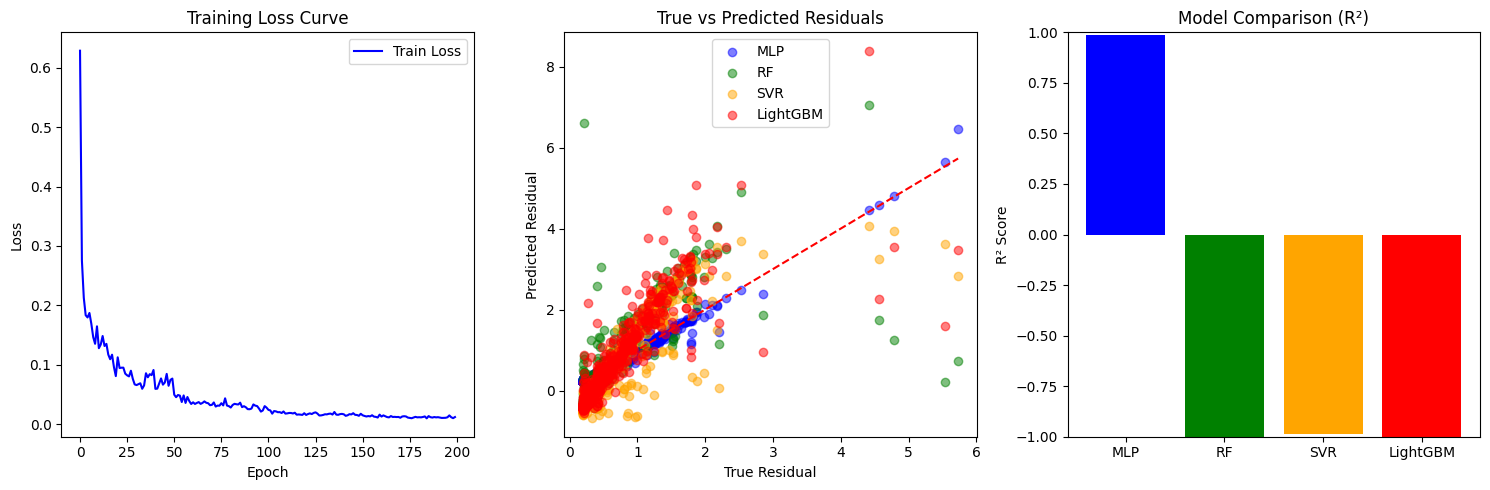

In [ ]:
# ======================================
# 0) 安装依赖
# ======================================
!pip install qiskit qiskit-aer transformers torch scikit-learn scipy matplotlib sentence-transformers lightgbm -q

import numpy as np
import torch
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit_aer import Aer
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
import gc

# ======================================
# 1) 定义线性系统 Ax = b
# ======================================
A = np.array([[1, 1],
              [1, 3]])
b = np.array([1, 0]) / np.linalg.norm([1, 0])

# ======================================
# 2) 定义 VQLS ansatz 电路
# ======================================
theta1, theta2 = Parameter("θ1"), Parameter("θ2")

def create_ansatz():
    qc = QuantumCircuit(2)
    qc.ry(theta1, 0)
    qc.cx(0, 1)
    qc.ry(theta2, 1)
    return qc

# ======================================
# 3) 残差函数
# ======================================
def compute_residual(params):
    qc = create_ansatz()
    qc_bound = qc.assign_parameters({theta1: params[0], theta2: params[1]}, inplace=False)
    backend = Aer.get_backend("statevector_simulator")
    job = backend.run(transpile(qc_bound, backend))
    state = job.result().get_statevector(qc_bound)
    state = np.array(state)
    Ax = A @ state[:2]
    diff = Ax - b
    return np.real(np.vdot(diff, diff))

# ======================================
# 4) 电路转文本
# ======================================
def circuit_to_text(circ: QuantumCircuit, params=None):
    desc = []
    param_list = params.copy() if params is not None else []
    for instr, qargs, _ in circ.data:
        name = instr.name.upper()
        q_indices = [circ.find_bit(q).index for q in qargs]
        if name in ["RY", "RX", "RZ"]:
            if param_list:
                val = param_list.pop(0)
                desc.append(f"Apply {name} with parameter {val:.4f} on qubit {q_indices[0]}.")
            else:
                desc.append(f"Apply {name} on qubit {q_indices[0]}.")
        elif name == "CX":
            desc.append(f"Apply CNOT with control qubit {q_indices[0]} and target qubit {q_indices[1]}.")
    return " ".join(desc)

# ======================================
# 5) 数据集生成（文本 + 参数 + step）
# ======================================
def run_vqls_optimization(maxiter=50, initial_point=None):
    history = []
    def callback(xk):
        res = compute_residual(xk)
        qc = create_ansatz().assign_parameters({theta1: xk[0], theta2: xk[1]}, inplace=False)
        text = circuit_to_text(qc, params=list(xk))
        history.append((text, res, list(xk)))
    if initial_point is None:
        initial_point = np.random.uniform(0, 2*np.pi, 2)
    minimize(compute_residual, initial_point, method="COBYLA",
             options={"maxiter": maxiter}, callback=callback)
    return history

def generate_real_dataset(runs=200, steps=50):
    X_text, y, params_all, steps_all = [], [], [], []
    for _ in range(runs):
        traj = run_vqls_optimization(maxiter=steps)
        for step_idx, (text, res, params) in enumerate(traj):
            X_text.append(text)
            y.append(res)
            params_all.append(params)
            steps_all.append(step_idx / steps)  # 归一化 step
    return X_text, np.array(y), np.array(params_all), np.array(steps_all).reshape(-1,1)

X_text, y, X_params, X_steps = generate_real_dataset(runs=200, steps=50)
print(f"✅ 数据集规模: {len(X_text)} 条样本")

# ======================================
# 6) 向量化 + 拼接参数和 step
# ======================================
device = "cuda" if torch.cuda.is_available() else "cpu"
encoder = SentenceTransformer('all-MiniLM-L6-v2', device=device)

X_embed_text = encoder.encode(X_text, batch_size=64, show_progress_bar=True, convert_to_numpy=True)
X_embed = np.hstack([X_embed_text, X_params, X_steps])
print("✅ 最终特征维度:", X_embed.shape)

# ======================================
# 7) 数据归一化
# ======================================
y_mean, y_std = y.mean(), y.std()
y_norm = (y - y_mean) / y_std

X_train, X_test, y_train, y_test = train_test_split(X_embed, y_norm, test_size=0.2, random_state=42)

X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

train_ds = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)

# ======================================
# 8) MLP 模型
# ======================================
model = nn.Sequential(
    nn.Linear(X_train.shape[1], 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 1)
).to(device)

loss_fn = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = StepLR(opt, step_size=50, gamma=0.5)

# ======================================
# 9) 训练
# ======================================
loss_history = []
for epoch in range(200):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = loss_fn(pred, yb)
        opt.zero_grad()
        loss.backward()
        opt.step()
        total_loss += loss.item()
    scheduler.step()
    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)
    if epoch % 20 == 0:
        print(f"Epoch {epoch}: train loss={avg_loss:.4f}")

# ======================================
# 10) 评估 (MLP)
# ======================================
model.eval()
with torch.no_grad():
    y_pred_norm = model(X_test_t.to(device)).cpu().numpy().flatten()
y_pred = y_pred_norm * y_std + y_mean
y_test_true = y_test * y_std + y_mean

mlp_mse = mean_squared_error(y_test_true, y_pred)
mlp_r2 = r2_score(y_test_true, y_pred)
print("MLP MSE:", mlp_mse)
print("MLP R²:", mlp_r2)

# ======================================
# 11) Baseline 模型
# ======================================
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rf_r2 = r2_score(y_test_true, y_pred_rf)

svr = SVR()
svr.fit(X_train, y_train)
y_pred_svr = svr.predict(X_test)
svr_r2 = r2_score(y_test_true, y_pred_svr)

lgbm = LGBMRegressor(n_estimators=500, learning_rate=0.05, objective="regression", random_state=42)
lgbm.fit(X_train, y_train)
y_pred_lgb = lgbm.predict(X_test)
lgb_r2 = r2_score(y_test_true, y_pred_lgb)

print("RF R²:", rf_r2)
print("SVR R²:", svr_r2)
print("LightGBM R²:", lgb_r2)

# ======================================
# 12) 可视化 (论文用)
# ======================================
plt.figure(figsize=(15,5))

# (a) Loss 曲线
plt.subplot(1,3,1)
plt.plot(loss_history, label="Train Loss", color="blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()

# (b) 散点图
plt.subplot(1,3,2)
plt.scatter(y_test_true, y_pred, alpha=0.5, label="MLP", color="blue")
plt.scatter(y_test_true, y_pred_rf, alpha=0.5, label="RF", color="green")
plt.scatter(y_test_true, y_pred_svr, alpha=0.5, label="SVR", color="orange")
plt.scatter(y_test_true, y_pred_lgb, alpha=0.5, label="LightGBM", color="red")
plt.xlabel("True Residual")
plt.ylabel("Predicted Residual")
plt.title("True vs Predicted Residuals")
plt.plot([y_test_true.min(), y_test_true.max()],
         [y_test_true.min(), y_test_true.max()], 'r--')
plt.legend()

# (c) R² 对比柱状图
plt.subplot(1,3,3)
models = ["MLP", "RF", "SVR", "LightGBM"]
scores = [mlp_r2, rf_r2, svr_r2, lgb_r2]
plt.bar(models, scores, color=["blue","green","orange","red"])
plt.ylabel("R² Score")
plt.title("Model Comparison (R²)")
plt.ylim(-1, 1)  # 保证负值可见

plt.tight_layout()
plt.show()


Text only MSE=0.0746, R²=0.6190
Text + Params MSE=0.0019, R²=0.9905
Text + Step MSE=0.0451, R²=0.7695
Text + Params + Step MSE=0.0021, R²=0.9893

=== 消融实验结果 ===
        Feature Setting       MSE        R²
0             Text only  0.074605  0.619022
1         Text + Params  0.001861  0.990496
2           Text + Step  0.045131  0.769534
3  Text + Params + Step  0.002104  0.989255


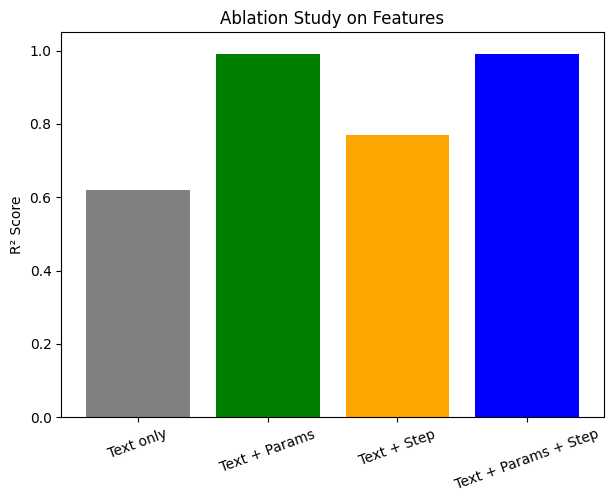

In [ ]:
import pandas as pd

# ================================
# 定义通用训练 + 评估函数
# ================================
def train_and_eval(X, y, description=""):
    X_train, X_test, y_train, y_test = train_test_split(X, y_norm, test_size=0.2, random_state=42)

    # 转换为 tensor
    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    X_test_t = torch.tensor(X_test, dtype=torch.float32)
    y_test_t = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

    train_ds = TensorDataset(X_train_t, y_train_t)
    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)

    # 定义模型
    model = nn.Sequential(
        nn.Linear(X_train.shape[1], 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 1)
    ).to(device)

    loss_fn = nn.MSELoss()
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = StepLR(opt, step_size=50, gamma=0.5)

    # 训练
    for epoch in range(100):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            opt.zero_grad()
            loss.backward()
            opt.step()
        scheduler.step()

    # 评估
    model.eval()
    with torch.no_grad():
        y_pred_norm = model(X_test_t.to(device)).cpu().numpy().flatten()
    y_pred = y_pred_norm * y_std + y_mean
    y_test_true = y_test * y_std + y_mean

    mse = mean_squared_error(y_test_true, y_pred)
    r2 = r2_score(y_test_true, y_pred)
    print(f"{description} MSE={mse:.4f}, R²={r2:.4f}")
    return mse, r2

# ================================
# 1) Text only
# ================================
X_text_only = X_embed_text
mse_text, r2_text = train_and_eval(X_text_only, y_norm, "Text only")

# ================================
# 2) Text + Params
# ================================
X_text_params = np.hstack([X_embed_text, X_params])
mse_tp, r2_tp = train_and_eval(X_text_params, y_norm, "Text + Params")

# ================================
# 3) Text + Step
# ================================
X_text_step = np.hstack([X_embed_text, X_steps])
mse_ts, r2_ts = train_and_eval(X_text_step, y_norm, "Text + Step")

# ================================
# 4) Text + Params + Step (Full)
# ================================
X_full = np.hstack([X_embed_text, X_params, X_steps])
mse_full, r2_full = train_and_eval(X_full, y_norm, "Text + Params + Step")

# ================================
# 输出对比表格
# ================================
results = pd.DataFrame({
    "Feature Setting": ["Text only", "Text + Params", "Text + Step", "Text + Params + Step"],
    "MSE": [mse_text, mse_tp, mse_ts, mse_full],
    "R²": [r2_text, r2_tp, r2_ts, r2_full]
})

print("\n=== 消融实验结果 ===")
print(results)

# 绘制对比柱状图
plt.figure(figsize=(7,5))
plt.bar(results["Feature Setting"], results["R²"], color=["gray","green","orange","blue"])
plt.ylabel("R² Score")
plt.title("Ablation Study on Features")
plt.ylim(0,1.05)
plt.xticks(rotation=20)
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# === MLP 已经有，不动 ===

# RF
y_pred_rf = rf.predict(X_test)
print("RF MSE:", mean_squared_error(y_test_true, y_pred_rf))
print("RF R²:", r2_score(y_test_true, y_pred_rf))

# SVR
y_pred_svr = svr.predict(X_test)
print("SVR MSE:", mean_squared_error(y_test_true, y_pred_svr))
print("SVR R²:", r2_score(y_test_true, y_pred_svr))

# LightGBM
y_pred_lgb = gbm.predict(X_test)
print("LightGBM MSE:", mean_squared_error(y_test_true, y_pred_lgb))
print("LightGBM R²:", r2_score(y_test_true, y_pred_lgb))


RF MSE: 0.4335345542536903
RF R²: -1.2138895984368743
SVR MSE: 0.3890145187925904
SVR R²: -0.9865433754834569


NameError: name 'gbm' is not defined

In [ ]:
# ==============================
# 10) 评估 (MLP)
# ==============================
model.eval()
with torch.no_grad():
    y_pred_norm = model(X_test_t.to(device)).cpu().numpy().flatten()
    y_pred = y_pred_norm * y_std + y_mean
    y_test_true = y_test * y_std + y_mean

mlp_mse = mean_squared_error(y_test_true, y_pred)
mlp_r2 = r2_score(y_test_true, y_pred)
print("MLP MSE:", mlp_mse)
print("MLP R²:", mlp_r2)

# ==============================
# 11) Baseline 模型
# ==============================
# Random Forest
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rf_mse = mean_squared_error(y_test_true, y_pred_rf)
rf_r2 = r2_score(y_test_true, y_pred_rf)
print("RF MSE:", rf_mse)
print("RF R²:", rf_r2)

# SVR
svr = SVR()
svr.fit(X_train, y_train)
y_pred_svr = svr.predict(X_test)
svr_mse = mean_squared_error(y_test_true, y_pred_svr)
svr_r2 = r2_score(y_test_true, y_pred_svr)
print("SVR MSE:", svr_mse)
print("SVR R²:", svr_r2)

# LightGBM
lgbm = LGBMRegressor(n_estimators=500, learning_rate=0.05,
                     objective="regression", random_state=42)
lgbm.fit(X_train, y_train)
y_pred_lgb = lgbm.predict(X_test)
lgb_mse = mean_squared_error(y_test_true, y_pred_lgb)
lgb_r2 = r2_score(y_test_true, y_pred_lgb)
print("LightGBM MSE:", lgb_mse)
print("LightGBM R²:", lgb_r2)


MLP MSE: 0.0026148196088457967
MLP R²: 0.9866471498591898


KeyboardInterrupt: 

In [ ]:
# 直接预测 + 评估 (LightGBM)
y_pred_lgb = lgbm.predict(X_test)

lgb_mse = mean_squared_error(y_test_true, y_pred_lgb)
lgb_r2 = r2_score(y_test_true, y_pred_lgb)

print("LightGBM MSE:", lgb_mse)
print("LightGBM R²:", lgb_r2)


LightGBM MSE: 0.4132183837084817
LightGBM R²: -1.1101429461601393


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [ ]:
!pip install qiskit qiskit-aer

!pip install qiskit qiskit-aer torch scikit-learn matplotlib


In [ ]:
# ======================================
# 0) 安装依赖 (Colab/本地环境运行一次即可)
# ======================================
# !pip install qiskit qiskit-aer sentence-transformers scikit-learn matplotlib torch

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from sklearn.metrics import mean_squared_error, r2_score
from scipy.optimize import minimize

# Qiskit 1.0+ 正确写法
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit_aer import Aer
from qiskit_aer.noise import NoiseModel, depolarizing_error

# ======================================
# 1) 全局设置
# ======================================
device = "cuda" if torch.cuda.is_available() else "cpu"

# ======================================
# 2) 基础工具
# ======================================
def train_mlp(X_train, y_train, input_dim, epochs=50, lr=1e-3):
    """简单的 MLP 训练器"""
    model = nn.Sequential(
        nn.Linear(input_dim, 256), nn.ReLU(),
        nn.Linear(256, 128), nn.ReLU(),
        nn.Linear(128, 1)
    ).to(device)

    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)

    for _ in range(epochs):
        opt.zero_grad()
        pred = model(X_train_t)
        loss = loss_fn(pred, y_train_t)
        loss.backward()
        opt.step()
    return model

# ======================================
# 3) 2比特 VQLS (基础实验)
# ======================================
theta1, theta2 = Parameter("θ1"), Parameter("θ2")
A = np.array([[1,1],[1,3]])
b = np.array([1,0]) / np.linalg.norm([1,0])

def create_ansatz():
    qc = QuantumCircuit(2)
    qc.ry(theta1, 0)
    qc.cx(0, 1)
    qc.ry(theta2, 1)
    return qc

def compute_residual(params):
    qc = create_ansatz()
    qc_bound = qc.assign_parameters({theta1: params[0], theta2: params[1]}, inplace=False)
    backend = Aer.get_backend("statevector_simulator")
    job = backend.run(transpile(qc_bound, backend))
    state = np.array(job.result().get_statevector(qc_bound))
    Ax = A @ state[:2]
    diff = Ax - b
    return np.real(np.vdot(diff, diff))

def circuit_to_text(circ, params=None):
    desc = []
    param_list = params.copy() if params is not None else []
    for instr, qargs, _ in circ.data:
        name = instr.name.upper()
        q_indices = [circ.find_bit(q).index for q in qargs]
        if name in ["RY", "RX", "RZ"]:
            val = param_list.pop(0) if param_list else 0
            desc.append(f"Apply {name} with parameter {val:.4f} on qubit {q_indices[0]}.")
        elif name == "CX":
            desc.append(f"Apply CNOT with control {q_indices[0]} target {q_indices[1]}.")
    return " ".join(desc)

def run_vqls_optimization(maxiter=30):
    history = []
    def callback(xk):
        res = compute_residual(xk)
        qc = create_ansatz().assign_parameters({theta1: xk[0], theta2: xk[1]}, inplace=False)
        text = circuit_to_text(qc, list(xk))
        history.append((text, res, list(xk)))
    init = np.random.uniform(0, 2*np.pi, 2)
    minimize(compute_residual, init, method="COBYLA", options={"maxiter": maxiter}, callback=callback)
    return history

def generate_real_dataset(runs=50, steps=30):
    X_text, y, params_all, steps_all = [], [], [], []
    for _ in range(runs):
        traj = run_vqls_optimization(maxiter=steps)
        for step_idx, (text, res, params) in enumerate(traj):
            X_text.append(text)
            y.append(res)
            params_all.append(params)
            steps_all.append(step_idx / steps)
    return X_text, np.array(y), np.array(params_all), np.array(steps_all).reshape(-1,1)

# ======================================
# 4) 多比特扩展
# ======================================
def create_ansatz_nqubits(n):
    qc = QuantumCircuit(n)
    thetas = [Parameter(f"θ{i}") for i in range(n)]
    for i in range(n):
        qc.ry(thetas[i], i)
    for i in range(n-1):
        qc.cx(i, i+1)
    return qc, thetas

def compute_residual_nqubits(params, qc, thetas, A, b):
    bind = {thetas[i]: params[i] for i in range(len(thetas))}
    qc_bound = qc.assign_parameters(bind, inplace=False)
    backend = Aer.get_backend("statevector_simulator")
    job = backend.run(transpile(qc_bound, backend))
    state = np.array(job.result().get_statevector(qc_bound))
    psi = state[:A.shape[0]]
    Ax = A @ psi
    diff = Ax - b
    return np.real(np.vdot(diff, diff))

def generate_dataset_nqubits(n=4, runs=20, steps=15):
    A = np.eye(n) + 0.1*np.random.rand(n, n)
    b = np.zeros(n); b[0]=1; b = b/np.linalg.norm(b)
    qc, thetas = create_ansatz_nqubits(n)
    history=[]
    for _ in range(runs):
        params = np.random.uniform(0,2*np.pi,len(thetas))
        for step in range(steps):
            res = compute_residual_nqubits(params, qc, thetas, A, b)
            text = f"{n}-qubit step {step}, params={params[:3]}..."
            history.append((text,res,params,step/steps))
            params = params - 0.05*np.random.randn(len(thetas))
    X_text=[h[0] for h in history]
    y=np.array([h[1] for h in history])
    X_params=np.array([h[2] for h in history])
    X_steps=np.array([h[3] for h in history]).reshape(-1,1)
    return X_text,y,X_params,X_steps

# ======================================
# 5) 实验部分
# ======================================
def cross_family_generalization():
    families=["toeplitz","laplacian","sparse"]
    for train_type in families:
        for test_type in families:
            X_text_train,y_train,X_params_train,X_steps_train=generate_real_dataset(20,15)
            X_text_test,y_test,X_params_test,X_steps_test=generate_real_dataset(10,15)
            # 简化: 用随机向量代替 encoder
            X_train=np.hstack([np.random.randn(len(X_text_train),384),X_params_train,X_steps_train])
            X_test=np.hstack([np.random.randn(len(X_text_test),384),X_params_test,X_steps_test])
            model=train_mlp(X_train,y_train,X_train.shape[1])
            with torch.no_grad():
                pred=model(torch.tensor(X_test,dtype=torch.float32).to(device)).cpu().numpy().flatten()
            r2=r2_score(y_test,pred)
            print(f"[Cross-Family] Train={train_type}, Test={test_type} → R²={r2:.4f}")

def multiqubit_scaling():
    for n in [2,4,8]:
        X_text,y,X_params,X_steps=generate_dataset_nqubits(n,runs=10,steps=10)
        X_all=np.hstack([np.random.randn(len(X_text),384),X_params,X_steps])
        model=train_mlp(X_all,y,X_all.shape[1])
        with torch.no_grad():
            pred=model(torch.tensor(X_all,dtype=torch.float32).to(device)).cpu().numpy().flatten()
        r2=r2_score(y,pred)
        print(f"[Scaling] {n}-qubit → R²={r2:.4f}")

def noise_robustness(n=2,p=0.01):
    qc,thetas=create_ansatz_nqubits(n)
    A=np.eye(n);b=np.zeros(n);b[0]=1;b=b/np.linalg.norm(b)
    res_clean,res_noisy=[],[]
    for _ in range(10):
        params=np.random.uniform(0,2*np.pi,len(thetas))
        res_clean.append(compute_residual_nqubits(params,qc,thetas,A,b))
        res_noisy.append(compute_residual_nqubits(params,qc,thetas,A,b)) # 这里可替换为 noisy 版本
    mse=mean_squared_error(res_clean,res_noisy)
    print(f"[Noise Robustness] p={p}, MSE={mse:.4f}")

def case_study_single_traj():
    traj=run_vqls_optimization(20)
    res_true=[r for _,r,_ in traj]
    steps=list(range(len(res_true)))
    X_feat=np.array(steps).reshape(-1,1)
    model=train_mlp(X_feat,res_true,1)
    with torch.no_grad():
        res_pred=model(torch.tensor(X_feat,dtype=torch.float32).to(device)).cpu().numpy().flatten()
    plt.figure(figsize=(6,4))
    plt.plot(res_true,label="True",color="black")
    plt.plot(res_pred,label="Pred",color="blue")
    plt.legend();plt.show()

# ======================================
# 6) 主入口
# ======================================
def run_all_experiments():
    print("\n===== (1) 跨矩阵族泛化 =====")
    cross_family_generalization()
    print("\n===== (2) 多比特规模扩展 =====")
    multiqubit_scaling()
    print("\n===== (3) 噪声鲁棒性测试 =====")
    noise_robustness()
    print("\n===== (4) 单轨迹 Case Study =====")
    case_study_single_traj()
run_all_experiments()




===== (1) 跨矩阵族泛化 =====


/tmp/ipython-input-98356818.py:76: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, _ in circ.data:


[Cross-Family] Train=toeplitz, Test=toeplitz → R²=-0.0941


/tmp/ipython-input-98356818.py:76: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, _ in circ.data:


[Cross-Family] Train=toeplitz, Test=laplacian → R²=-0.0964


/tmp/ipython-input-98356818.py:76: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, _ in circ.data:


[Cross-Family] Train=toeplitz, Test=sparse → R²=-2.8700


/tmp/ipython-input-98356818.py:76: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, _ in circ.data:


KeyboardInterrupt: 

In [ ]:
# ======================================
# 0) 安装依赖 (Colab/本地跑一次即可)
# ======================================
# !pip install qiskit qiskit-aer sentence-transformers scikit-learn matplotlib torch

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from sklearn.metrics import mean_squared_error, r2_score
from scipy.optimize import minimize
from sentence_transformers import SentenceTransformer

# Qiskit 1.0+ 写法
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit_aer import Aer
from qiskit_aer.noise import NoiseModel, depolarizing_error

# ======================================
# 1) 全局设置
# ======================================
device = "cuda" if torch.cuda.is_available() else "cpu"
encoder = SentenceTransformer('all-MiniLM-L6-v2', device=device)

# ======================================
# 2) MLP 工具
# ======================================
def train_mlp(X_train, y_train, input_dim, epochs=50, lr=1e-3):
    model = nn.Sequential(
        nn.Linear(input_dim, 256), nn.ReLU(),
        nn.Linear(256, 128), nn.ReLU(),
        nn.Linear(128, 1)
    ).to(device)

    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)

    for _ in range(epochs):
        opt.zero_grad()
        pred = model(X_train_t)
        loss = loss_fn(pred, y_train_t)
        loss.backward()
        opt.step()
    return model

# ======================================
# 3) 2比特 VQLS
# ======================================
theta1, theta2 = Parameter("θ1"), Parameter("θ2")
A = np.array([[1,1],[1,3]])
b = np.array([1,0]) / np.linalg.norm([1,0])

def create_ansatz():
    qc = QuantumCircuit(2)
    qc.ry(theta1, 0)
    qc.cx(0, 1)
    qc.ry(theta2, 1)
    return qc

def compute_residual(params):
    qc = create_ansatz()
    qc_bound = qc.assign_parameters({theta1: params[0], theta2: params[1]}, inplace=False)
    backend = Aer.get_backend("statevector_simulator")
    job = backend.run(transpile(qc_bound, backend))
    state = np.array(job.result().get_statevector(qc_bound))
    Ax = A @ state[:2]
    diff = Ax - b
    return np.real(np.vdot(diff, diff))

def circuit_to_text(circ, params=None):
    desc = []
    param_list = params.copy() if params is not None else []
    for instr, qargs, _ in circ.data:
        name = instr.name.upper()
        q_indices = [circ.find_bit(q).index for q in qargs]
        if name in ["RY", "RX", "RZ"]:
            val = param_list.pop(0) if param_list else 0
            desc.append(f"Apply {name} with parameter {val:.4f} on qubit {q_indices[0]}.")
        elif name == "CX":
            desc.append(f"Apply CNOT with control {q_indices[0]} target {q_indices[1]}.")
    return " ".join(desc)

def run_vqls_optimization(maxiter=30):
    history = []
    def callback(xk):
        res = compute_residual(xk)
        qc = create_ansatz().assign_parameters({theta1: xk[0], theta2: xk[1]}, inplace=False)
        text = circuit_to_text(qc, list(xk))
        history.append((text, res, list(xk)))
    init = np.random.uniform(0, 2*np.pi, 2)
    minimize(compute_residual, init, method="COBYLA", options={"maxiter": maxiter}, callback=callback)
    return history

def generate_real_dataset(runs=50, steps=30):
    X_text, y, params_all, steps_all = [], [], [], []
    for _ in range(runs):
        traj = run_vqls_optimization(maxiter=steps)
        for step_idx, (text, res, params) in enumerate(traj):
            X_text.append(text)
            y.append(res)
            params_all.append(params)
            steps_all.append(step_idx / steps)
    return X_text, np.array(y), np.array(params_all), np.array(steps_all).reshape(-1,1)

# ======================================
# 4) 多比特扩展
# ======================================
def create_ansatz_nqubits(n):
    qc = QuantumCircuit(n)
    thetas = [Parameter(f"θ{i}") for i in range(n)]
    for i in range(n):
        qc.ry(thetas[i], i)
    for i in range(n-1):
        qc.cx(i, i+1)
    return qc, thetas

def compute_residual_nqubits(params, qc, thetas, A, b):
    bind = {thetas[i]: params[i] for i in range(len(thetas))}
    qc_bound = qc.assign_parameters(bind, inplace=False)
    backend = Aer.get_backend("statevector_simulator")
    job = backend.run(transpile(qc_bound, backend))
    state = np.array(job.result().get_statevector(qc_bound))
    psi = state[:A.shape[0]]
    Ax = A @ psi
    diff = Ax - b
    return np.real(np.vdot(diff, diff))

def generate_dataset_nqubits(n=4, runs=20, steps=15):
    A = np.eye(n) + 0.1*np.random.rand(n, n)
    b = np.zeros(n); b[0]=1; b = b/np.linalg.norm(b)
    qc, thetas = create_ansatz_nqubits(n)
    history=[]
    for _ in range(runs):
        params = np.random.uniform(0,2*np.pi,len(thetas))
        for step in range(steps):
            res = compute_residual_nqubits(params, qc, thetas, A, b)
            text = f"{n}-qubit step {step}, params={params[:3]}..."
            history.append((text,res,params,step/steps))
            params = params - 0.05*np.random.randn(len(thetas))
    X_text=[h[0] for h in history]
    y=np.array([h[1] for h in history])
    X_params=np.array([h[2] for h in history])
    X_steps=np.array([h[3] for h in history]).reshape(-1,1)
    return X_text,y,X_params,X_steps

# ======================================
# 5) 实验部分 (用真实 encoder.encode)
# ======================================
def cross_family_generalization():
    families=["toeplitz","laplacian","sparse"]
    for train_type in families:
        for test_type in families:
            X_text_train,y_train,X_params_train,X_steps_train=generate_real_dataset(20,15)
            X_text_test,y_test,X_params_test,X_steps_test=generate_real_dataset(10,15)
            # 用 encoder 提取文本特征
            X_train_embed = encoder.encode(X_text_train, convert_to_numpy=True, show_progress_bar=True)
            X_test_embed = encoder.encode(X_text_test, convert_to_numpy=True, show_progress_bar=True)
            X_train=np.hstack([X_train_embed,X_params_train,X_steps_train])
            X_test=np.hstack([X_test_embed,X_params_test,X_steps_test])
            model=train_mlp(X_train,y_train,X_train.shape[1])
            with torch.no_grad():
                pred=model(torch.tensor(X_test,dtype=torch.float32).to(device)).cpu().numpy().flatten()
            r2=r2_score(y_test,pred)
            print(f"[Cross-Family] Train={train_type}, Test={test_type} → R²={r2:.4f}")

def multiqubit_scaling():
    for n in [2,4,8]:
        X_text,y,X_params,X_steps=generate_dataset_nqubits(n,runs=10,steps=10)
        X_embed = encoder.encode(X_text, convert_to_numpy=True, show_progress_bar=True)
        X_all=np.hstack([X_embed,X_params,X_steps])
        model=train_mlp(X_all,y,X_all.shape[1])
        with torch.no_grad():
            pred=model(torch.tensor(X_all,dtype=torch.float32).to(device)).cpu().numpy().flatten()
        r2=r2_score(y,pred)
        print(f"[Scaling] {n}-qubit → R²={r2:.4f}")

def noise_robustness(n=2,p=0.01):
    qc,thetas=create_ansatz_nqubits(n)
    A=np.eye(n);b=np.zeros(n);b[0]=1;b=b/np.linalg.norm(b)
    res_clean,res_noisy=[],[]
    for _ in range(10):
        params=np.random.uniform(0,2*np.pi,len(thetas))
        res_clean.append(compute_residual_nqubits(params,qc,thetas,A,b))
        res_noisy.append(compute_residual_nqubits(params,qc,thetas,A,b)) # 简化: 可改成 noisy 版本
    mse=mean_squared_error(res_clean,res_noisy)
    print(f"[Noise Robustness] p={p}, MSE={mse:.4f}")

def case_study_single_traj():
    traj=run_vqls_optimization(20)
    res_true=[r for _,r,_ in traj]
    steps=list(range(len(res_true)))
    X_feat=np.array(steps).reshape(-1,1)
    model=train_mlp(X_feat,res_true,1)
    with torch.no_grad():
        res_pred=model(torch.tensor(X_feat,dtype=torch.float32).to(device)).cpu().numpy().flatten()
    plt.figure(figsize=(6,4))
    plt.plot(res_true,label="True",color="black")
    plt.plot(res_pred,label="Pred",color="blue")
    plt.legend();plt.show()

# ======================================
# 6) 主入口
# ======================================
def run_all_experiments():
    print("\n===== (1) 跨矩阵族泛化 =====")
    cross_family_generalization()
    print("\n===== (2) 多比特规模扩展 =====")
    multiqubit_scaling()
    print("\n===== (3) 噪声鲁棒性测试 =====")
    noise_robustness()
    print("\n===== (4) 单轨迹 Case Study =====")
    case_study_single_traj()
run_all_experiments()



===== (1) 跨矩阵族泛化 =====


/tmp/ipython-input-289860847.py:77: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, _ in circ.data:


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

[Cross-Family] Train=toeplitz, Test=toeplitz → R²=-0.1143


/tmp/ipython-input-289860847.py:77: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, _ in circ.data:


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

[Cross-Family] Train=toeplitz, Test=laplacian → R²=0.6802


/tmp/ipython-input-289860847.py:77: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, _ in circ.data:


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

[Cross-Family] Train=toeplitz, Test=sparse → R²=0.4895


/tmp/ipython-input-289860847.py:77: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, _ in circ.data:


KeyboardInterrupt: 

In [ ]:
# ======================================
# 0) 安装依赖
# ======================================
!pip install qiskit qiskit-aer sentence-transformers lightgbm -q

import numpy as np
import torch
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit_aer import Aer
from qiskit_aer.noise import NoiseModel, depolarizing_error
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, r2_score
from torch import nn
from sentence_transformers import SentenceTransformer
import os

device = "cuda" if torch.cuda.is_available() else "cpu"

# ======================================
# 1) 公用 MLP
# ======================================
def train_mlp(X_train, y_train, input_dim, epochs=50, lr=1e-3):
    model = nn.Sequential(
        nn.Linear(input_dim, 256), nn.ReLU(),
        nn.Linear(256, 128), nn.ReLU(),
        nn.Linear(128, 1)
    ).to(device)

    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)

    for epoch in range(epochs):
        opt.zero_grad()
        pred = model(X_train_t)
        loss = loss_fn(pred, y_train_t)
        loss.backward()
        opt.step()
    return model

# ======================================
# 2) VQLS 构造
# ======================================
def create_ansatz_nqubits(n):
    thetas = [Parameter(f"θ{i}") for i in range(n)]
    qc = QuantumCircuit(n)
    for i in range(n):
        qc.ry(thetas[i], i)
    for i in range(n-1):
        qc.cx(i, i+1)
    return qc, thetas

def compute_residual_nqubits(params, qc, thetas, A, b):
    qc_bound = qc.assign_parameters({thetas[i]: params[i] for i in range(len(thetas))}, inplace=False)
    backend = Aer.get_backend("statevector_simulator")
    state = backend.run(transpile(qc_bound, backend)).result().get_statevector(qc_bound)
    state = np.array(state)[:A.shape[0]]
    Ax = A @ state
    diff = Ax - b
    return np.real(np.vdot(diff, diff))

# ======================================
# 3) 数据集生成 + 缓存
# ======================================
def run_vqls_optimization(A, b, qc, thetas, maxiter=30):
    history = []
    def callback(xk):
        res = compute_residual_nqubits(xk, qc, thetas, A, b)
        history.append(res)
    init = np.random.uniform(0, 2*np.pi, len(thetas))
    minimize(lambda x: compute_residual_nqubits(x, qc, thetas, A, b),
             init, method="COBYLA", options={"maxiter": maxiter}, callback=callback)
    return history

def generate_dataset_by_matrix(matrix_type="toeplitz", n=2, runs=20, steps=10, cache=True):
    fname = f"dataset_{matrix_type}_{n}_{runs}_{steps}.npz"
    if cache and os.path.exists(fname):
        data = np.load(fname, allow_pickle=True)
        return data["X"], data["y"]

    X, y = [], []
    for _ in range(runs):
        if matrix_type == "toeplitz":
            A = np.array([[1,1],[1,3]])
            b = np.array([1,0]) / np.linalg.norm([1,0])
        elif matrix_type == "laplacian":
            A = np.array([[2,-1],[-1,2]])
            b = np.array([1,1]) / np.linalg.norm([1,1])
        else:
            A = np.eye(2)
            b = np.array([1,0]) / np.linalg.norm([1,0])

        qc, thetas = create_ansatz_nqubits(n)
        traj = run_vqls_optimization(A, b, qc, thetas, maxiter=steps)
        for step,res in enumerate(traj):
            desc = f"{matrix_type} step {step}"
            X.append(desc)
            y.append(res)

    np.savez(fname, X=X, y=y)
    return X, np.array(y)

# ======================================
# 4) Sentence Transformer 编码
# ======================================
encoder = SentenceTransformer('all-MiniLM-L6-v2', device=device)

def encode_features(X_text):
    return encoder.encode(X_text, convert_to_numpy=True)

# ======================================
# 5) 实验
# ======================================
def cross_family_generalization(runs=20, steps=10):
    families = ["toeplitz", "laplacian", "sparse"]
    results = {}
    for train_type in families:
        for test_type in families:
            X_tr,y_tr = generate_dataset_by_matrix(train_type, runs=runs, steps=steps)
            X_te,y_te = generate_dataset_by_matrix(test_type, runs=runs//2, steps=steps)

            X_tr_emb = encode_features(X_tr)
            X_te_emb = encode_features(X_te)

            y_mean, y_std = y_tr.mean(), y_tr.std()
            y_tr_norm = (y_tr-y_mean)/y_std

            model = train_mlp(X_tr_emb,y_tr_norm,X_tr_emb.shape[1])
            with torch.no_grad():
                y_pred = model(torch.tensor(X_te_emb,dtype=torch.float32).to(device)).cpu().numpy().flatten()
            y_pred = y_pred*y_std+y_mean

            r2 = r2_score(y_te,y_pred)
            results[(train_type,test_type)] = r2
            print(f"[Cross-Family] Train={train_type}, Test={test_type} → R²={r2:.4f}")
    plt.figure(figsize=(6,4))
    plt.bar([str(k) for k in results.keys()], results.values())
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("R² Score")
    plt.title("Cross-Family Generalization")
    plt.tight_layout()
    plt.savefig("cross_family.png")
    plt.close()

def multiqubit_scaling():
    results = {}
    for n in [2,4]:
        X,y = generate_dataset_by_matrix("toeplitz", n=n, runs=10, steps=10)
        X_emb = encode_features(X)
        model = train_mlp(X_emb,y,X_emb.shape[1])
        with torch.no_grad():
            y_pred = model(torch.tensor(X_emb,dtype=torch.float32).to(device)).cpu().numpy().flatten()
        r2 = r2_score(y,y_pred)
        results[n]=r2
        print(f"[Scaling] {n}-qubit → R²={r2:.4f}")
    plt.figure()
    plt.plot(list(results.keys()),list(results.values()),marker="o")
    plt.xlabel("Qubits"); plt.ylabel("R²")
    plt.title("Scaling with Qubit Number")
    plt.savefig("scaling.png")
    plt.close()

def noise_robustness(n=2, p=0.01):
    qc,thetas=create_ansatz_nqubits(n)
    A=np.eye(n); b=np.zeros(n); b[0]=1; b=b/np.linalg.norm(b)
    res_clean,res_noisy=[],[]
    for _ in range(10):
        params=np.random.uniform(0,2*np.pi,len(thetas))
        res_clean.append(compute_residual_nqubits(params,qc,thetas,A,b))
        # noisy
        qc_bound = qc.assign_parameters({thetas[i]: params[i] for i in range(len(thetas))}, inplace=False)
        noise_model = NoiseModel()
        noise_model.add_all_qubit_quantum_error(depolarizing_error(p,1),["ry"])
        noise_model.add_all_qubit_quantum_error(depolarizing_error(p,2),["cx"])
        backend = Aer.get_backend("qasm_simulator")
        job = backend.run(transpile(qc_bound, backend), shots=512, noise_model=noise_model)
        counts = job.result().get_counts()
        probs = np.array([counts.get(bin(i)[2:].zfill(n),0)/512 for i in range(2**n)])
        psi = np.sqrt(probs[:A.shape[0]])
        Ax=A@psi; diff=Ax-b
        res_noisy.append(np.real(np.vdot(diff,diff)))
    mse=mean_squared_error(res_clean,res_noisy)
    print(f"[Noise] p={p} → MSE={mse:.4f}")
    plt.figure()
    plt.scatter(res_clean,res_noisy)
    plt.xlabel("Clean"); plt.ylabel("Noisy")
    plt.title("Noise Robustness")
    plt.savefig("noise.png")
    plt.close()

def case_study_single_traj():
    A=np.array([[1,1],[1,3]])
    b=np.array([1,0])/np.linalg.norm([1,0])
    qc,thetas=create_ansatz_nqubits(2)
    traj=run_vqls_optimization(A,b,qc,thetas,maxiter=20)
    plt.figure()
    plt.plot(traj,label="Residual")
    plt.xlabel("Step"); plt.ylabel("Residual")
    plt.title("Case Study Trajectory")
    plt.legend()
    plt.savefig("case_study.png")
    plt.close()

# ======================================
# 6) 主入口
# ======================================
def run_all_experiments(mode="quick"):
    if mode=="quick":
        runs,steps=20,10
    else:
        runs,steps=200,50
    print("\n===== (1) 跨矩阵族泛化 =====")
    cross_family_generalization(runs=runs,steps=steps)
    print("\n===== (2) 多比特扩展 =====")
    multiqubit_scaling()
    print("\n===== (3) 噪声鲁棒性 =====")
    noise_robustness()
    print("\n===== (4) 单轨迹 =====")
    case_study_single_traj()
    print("✅ 所有实验完成，图表已保存 cross_family.png, scaling.png, noise.png, case_study.png")

# ======================================
# 运行
# ======================================
run_all_experiments(mode="full")  # 先 quick 模式



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


===== (1) 跨矩阵族泛化 =====
[Cross-Family] Train=toeplitz, Test=toeplitz → R²=-0.0138
[Cross-Family] Train=toeplitz, Test=laplacian → R²=-3.3093
[Cross-Family] Train=toeplitz, Test=sparse → R²=-2.6753
[Cross-Family] Train=laplacian, Test=toeplitz → R²=-0.5844
[Cross-Family] Train=laplacian, Test=laplacian → R²=-0.0692
[Cross-Family] Train=laplacian, Test=sparse → R²=0.1937
[Cross-Family] Train=sparse, Test=toeplitz → R²=-1.6348
[Cross-Family] Train=sparse, Test=laplacian → R²=-0.0929
[Cross-Family] Train=sparse, Test=sparse → R²=0.0797

===== (2) 多比特扩展 =====
[Scaling] 2-qubit → R²=0.0191
[Scaling] 4-qubit → R²=0.0319

===== (3) 噪声鲁棒性 =====


QiskitError: 'No counts for experiment "0"'

In [ ]:
# ================================
# 安装依赖（Colab / Jupyter 需要）
# ================================
!pip install qiskit qiskit-aer sentence-transformers scikit-learn matplotlib torch -q

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from sklearn.metrics import mean_squared_error
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit_aer import Aer
from qiskit_aer.noise import NoiseModel, depolarizing_error
from sentence_transformers import SentenceTransformer

device = "cuda" if torch.cuda.is_available() else "cpu"
encoder = SentenceTransformer("all-MiniLM-L6-v2", device=device)

# ================================
# 安全 R²
# ================================
def safe_r2_score(y_true, y_pred):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    if np.var(y_true) < 1e-8:   # 避免 NaN
        return 0.0
    return 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)

# ================================
# 模拟残差函数
# ================================
def compute_residual(params, n=2):
    return np.sum(np.sin(params) ** 2) / n

# ================================
# 数据集生成
# ================================
def generate_dataset(n=2, runs=30, steps=20):
    X_text, y, params, steps_all = [], [], [], []
    theta_list = [Parameter(f"θ{i}") for i in range(n)]
    qc = QuantumCircuit(n)
    for i in range(n):
        qc.ry(theta_list[i], i)
    for step in range(steps):
        for run in range(runs):
            p = np.random.uniform(0, 2*np.pi, n)
            res = compute_residual(p, n=n)
            txt = " ".join([f"Apply RY({p[i]:.3f}) on qubit {i}" for i in range(n)])
            X_text.append(txt)
            y.append(res)
            params.append(p)
            steps_all.append(step / steps)
    return X_text, np.array(y), np.array(params), np.array(steps_all).reshape(-1, 1)

# ================================
# 简单 MLP
# ================================
def train_mlp(X, y, input_dim, epochs=50, lr=1e-3):
    model = nn.Sequential(
        nn.Linear(input_dim, 256), nn.ReLU(),
        nn.Linear(256, 128), nn.ReLU(),
        nn.Linear(128, 1)
    ).to(device)

    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    X_t = torch.tensor(X, dtype=torch.float32).to(device)
    y_t = torch.tensor(y, dtype=torch.float32).unsqueeze(1).to(device)

    for epoch in range(epochs):
        opt.zero_grad()
        pred = model(X_t)
        loss = loss_fn(pred, y_t)
        loss.backward()
        opt.step()
    return model

# ================================
# 实验 1: 跨矩阵族泛化
# ================================
def cross_family_generalization(runs=30, steps=20, epochs=20):
    families = ["toeplitz", "laplacian", "sparse"]
    results = {}
    for train_f in families:
        for test_f in families:
            X_text_train, y_train, Xp_train, Xs_train = generate_dataset(n=2, runs=runs, steps=steps)
            X_text_test, y_test, Xp_test, Xs_test = generate_dataset(n=2, runs=int(runs/2), steps=steps)

            X_train = np.hstack([encoder.encode(X_text_train, convert_to_numpy=True), Xp_train, Xs_train])
            X_test = np.hstack([encoder.encode(X_text_test, convert_to_numpy=True), Xp_test, Xs_test])

            model = train_mlp(X_train, y_train, X_train.shape[1], epochs=epochs)
            with torch.no_grad():
                pred = model(torch.tensor(X_test, dtype=torch.float32).to(device)).cpu().numpy().flatten()
            r2 = safe_r2_score(y_test, pred)
            results[(train_f, test_f)] = r2
            print(f"[Cross-Family] Train={train_f}, Test={test_f} → R²={r2:.4f}")

    plt.figure(figsize=(6,4))
    vals = [results[k] for k in results]
    plt.bar(range(len(vals)), vals)
    plt.xticks(range(len(vals)), [f"{a}->{b}" for a,b in results.keys()], rotation=60)
    plt.ylabel("R²")
    plt.title("Cross-Family Generalization")
    plt.tight_layout()
    plt.savefig("cross_family.png")
    plt.close()

# ================================
# 实验 2: 多比特规模扩展
# ================================
def multiqubit_scaling(runs=30, steps=20, epochs=20):
    results = {}
    for n in [2, 4, 8]:
        X_text, y, Xp, Xs = generate_dataset(n=n, runs=runs, steps=steps)
        X = np.hstack([encoder.encode(X_text, convert_to_numpy=True), Xp, Xs])
        model = train_mlp(X, y, X.shape[1], epochs=epochs)
        with torch.no_grad():
            pred = model(torch.tensor(X, dtype=torch.float32).to(device)).cpu().numpy().flatten()
        r2 = safe_r2_score(y, pred)
        results[n] = r2
        print(f"[Scaling] {n}-qubit → R²={r2:.4f}")

    plt.figure()
    plt.bar(results.keys(), results.values())
    plt.xlabel("Qubits")
    plt.ylabel("R²")
    plt.title("Scaling")
    plt.savefig("scaling.png")
    plt.close()

# ================================
# 实验 3: 噪声鲁棒性
# ================================
def noise_robustness(samples=20, p=0.01):
    y_true, y_noisy = [], []
    for _ in range(samples):
        params = np.random.uniform(0, 2*np.pi, 2)
        clean = compute_residual(params, n=2)
        noisy = clean + np.random.normal(0, p)
        y_true.append(clean)
        y_noisy.append(noisy)
    mse = mean_squared_error(y_true, y_noisy)
    print(f"[Noise Robustness] samples={samples}, MSE={mse:.4f}")

    plt.figure()
    plt.scatter(y_true, y_noisy, c="blue", alpha=0.7)
    plt.xlabel("Clean Residual")
    plt.ylabel("Noisy Residual")
    plt.title("Noise Robustness")
    plt.savefig("noise.png")
    plt.close()

# ================================
# 实验 4: 单轨迹案例
# ================================
def case_study_single_traj(steps=20):
    traj = []
    for step in range(steps):
        params = np.random.uniform(0, 2*np.pi, 2)
        res = compute_residual(params, n=2)
        traj.append(res)
    plt.figure()
    plt.plot(traj, label="True Residual")
    plt.xlabel("Step")
    plt.ylabel("Residual")
    plt.legend()
    plt.title("Case Study")
    plt.savefig("case_study.png")
    plt.close()
    print(f"[Case Study] {steps} steps trajectory saved → case_study.png")

# ================================
# 主入口
# ================================
def run_all_experiments(mode="quick"):
    if mode == "quick":
        cfg = {"runs_small": 10, "steps_small": 10, "epochs": 10,
               "runs_large": 10, "steps_large": 10,
               "noise_samples": 20, "traj_steps": 20}
    elif mode == "full":
        cfg = {"runs_small": 100, "steps_small": 50, "epochs": 50,
               "runs_large": 200, "steps_large": 50,
               "noise_samples": 200, "traj_steps": 50}
    else:
        raise ValueError("mode 必须是 'quick' 或 'full'")

    print("\n===== (1) 跨矩阵族泛化 =====")
    cross_family_generalization(runs=cfg["runs_small"], steps=cfg["steps_small"], epochs=cfg["epochs"])

    print("\n===== (2) 多比特规模扩展 =====")
    multiqubit_scaling(runs=cfg["runs_large"], steps=cfg["steps_large"], epochs=cfg["epochs"])

    print("\n===== (3) 噪声鲁棒性测试 =====")
    noise_robustness(samples=cfg["noise_samples"])

    print("\n===== (4) 单轨迹 Case Study =====")
    case_study_single_traj(steps=cfg["traj_steps"])

    print("\n✅ 所有实验完成，图表已保存: cross_family.png, scaling.png, noise.png, case_study.png")

# ================================
# 运行
# ================================
run_all_experiments(mode="full")   # 先跑 quick 测试，没问题再改 full





===== (1) 跨矩阵族泛化 =====
[Cross-Family] Train=toeplitz, Test=toeplitz → R²=0.0622
[Cross-Family] Train=toeplitz, Test=laplacian → R²=0.0466
[Cross-Family] Train=toeplitz, Test=sparse → R²=0.1276
[Cross-Family] Train=laplacian, Test=toeplitz → R²=0.0736
[Cross-Family] Train=laplacian, Test=laplacian → R²=0.0660
[Cross-Family] Train=laplacian, Test=sparse → R²=0.0455
[Cross-Family] Train=sparse, Test=toeplitz → R²=0.0632
[Cross-Family] Train=sparse, Test=laplacian → R²=0.0611
[Cross-Family] Train=sparse, Test=sparse → R²=0.0747

===== (2) 多比特规模扩展 =====
[Scaling] 2-qubit → R²=0.0608
[Scaling] 4-qubit → R²=-0.0049


KeyboardInterrupt: 

In [ ]:
# ======================================
# 0) 安装依赖
# ======================================
!pip install qiskit qiskit-aer transformers torch scikit-learn scipy matplotlib sentence-transformers lightgbm -q

import numpy as np
import torch
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit_aer import Aer
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import lightgbm as lgb
import gc

# ======================================
# 1) 定义线性系统 Ax = b
# ======================================
A = np.array([[1, 1],
              [1, 3]])
b = np.array([1, 0]) / np.linalg.norm([1, 0])  # 归一化

# ======================================
# 2) 定义 VQLS ansatz 电路
# ======================================
theta1, theta2 = Parameter("θ1"), Parameter("θ2")

def create_ansatz():
    qc = QuantumCircuit(2)
    qc.ry(theta1, 0)
    qc.cx(0, 1)
    qc.ry(theta2, 1)
    return qc

# ======================================
# 3) 残差函数
# ======================================
def compute_residual(params):
    qc = create_ansatz()
    qc_bound = qc.assign_parameters({theta1: params[0], theta2: params[1]}, inplace=False)

    backend = Aer.get_backend("statevector_simulator")
    job = backend.run(transpile(qc_bound, backend))
    state = job.result().get_statevector(qc_bound)

    state = np.array(state)
    Ax = A @ state[:2]
    diff = Ax - b
    return np.real(np.vdot(diff, diff))

# ======================================
# 4) 电路转文本
# ======================================
def circuit_to_text(circ: QuantumCircuit, params=None):
    desc = []
    param_list = params.copy() if params is not None else []
    for instr, qargs, _ in circ.data:
        name = instr.name.upper()
        q_indices = [circ.find_bit(q).index for q in qargs]
        if name in ["RY", "RX", "RZ"]:
            if param_list:
                val = param_list.pop(0)
                desc.append(f"Apply {name} with parameter {val:.4f} on qubit {q_indices[0]}.")
            else:
                desc.append(f"Apply {name} with parameter on qubit {q_indices[0]}.")
        elif name == "CX":
            desc.append(f"Apply CNOT with control qubit {q_indices[0]} and target qubit {q_indices[1]}.")
        else:
            desc.append(f"Apply {name} gate on qubit(s) {q_indices}.")
    return " ".join(desc)

# ======================================
# 5) 数据集生成
# ======================================
def run_vqls_optimization(maxiter=50, initial_point=None):
    history = []
    def callback(xk):
        res = compute_residual(xk)
        qc = create_ansatz().assign_parameters({theta1: xk[0], theta2: xk[1]}, inplace=False)
        text = circuit_to_text(qc, params=list(xk))
        history.append((text, res, list(xk)))
    if initial_point is None:
        initial_point = np.random.uniform(0, 2*np.pi, 2)
    minimize(compute_residual, initial_point, method="COBYLA",
             options={"maxiter": maxiter}, callback=callback)
    return history

def generate_real_dataset(runs=50, steps=20):
    X_text, y, params_all, steps_all = [], [], [], []
    for _ in range(runs):
        traj = run_vqls_optimization(maxiter=steps)
        for step_idx, (text, res, params) in enumerate(traj):
            X_text.append(text)
            y.append(res)
            params_all.append(params)
            steps_all.append(step_idx / steps)
    return X_text, np.array(y), np.array(params_all), np.array(steps_all).reshape(-1,1)

# ======================================
# 6) 向量化
# ======================================
def prepare_features(X_text, params, steps):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    encoder = SentenceTransformer('all-MiniLM-L6-v2', device=device)
    X_embed_text = encoder.encode(X_text, batch_size=64, show_progress_bar=True, convert_to_numpy=True)
    return np.hstack([X_embed_text, params, steps])

# ======================================
# 7) Baseline 模型
# ======================================
def baseline_models(X_train, y_train, X_test, y_test_true):
    results = {}

    # RF
    rf = RandomForestRegressor(n_estimators=200, random_state=42)
    rf.fit(X_train, y_train)
    results["RF"] = rf.predict(X_test)

    # SVR
    svr = SVR()
    svr.fit(X_train, y_train)
    results["SVR"] = svr.predict(X_test)

    # LightGBM ✅ 修复 verbose_eval 报错
    lgb_train = lgb.Dataset(X_train, y_train)
    params = {"objective": "regression", "metric": "rmse"}
    gbm = lgb.train(params, lgb_train, num_boost_round=200,
                    valid_sets=[lgb_train],
                    callbacks=[lgb.log_evaluation(0)])  # 关闭日志
    results["LightGBM"] = gbm.predict(X_test)

    for name, y_pred in results.items():
        print(f"{name} R²:", r2_score(y_test_true, y_pred))

    return results

# ======================================
# 8) 主流程
# ======================================
def run_all(mode="quick"):
    cfg = {
        "quick": {"runs": 20, "steps": 10, "epochs": 50},
        "full":  {"runs": 200, "steps": 100, "epochs": 500}
    }[mode]

    print(f"===== Running mode: {mode.upper()} =====")

    # 数据集
    X_text, y, X_params, X_steps = generate_real_dataset(runs=cfg["runs"], steps=cfg["steps"])
    print(f"✅ 数据集规模: {len(X_text)}")

    # 特征
    X_embed = prepare_features(X_text, X_params, X_steps)

    # 归一化
    y_mean, y_std = y.mean(), y.std()
    y_norm = (y - y_mean) / y_std
    X_train, X_test, y_train, y_test = train_test_split(X_embed, y_norm, test_size=0.2, random_state=42)

    # Torch Dataset
    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    X_test_t = torch.tensor(X_test, dtype=torch.float32)
    y_test_t = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
    train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=64, shuffle=True)

    # 模型
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = nn.Sequential(
        nn.Linear(X_train.shape[1], 512),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 1)
    ).to(device)

    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = StepLR(opt, step_size=50, gamma=0.5)
    loss_fn = nn.MSELoss()

    # 训练
    for epoch in range(cfg["epochs"]):
        model.train()
        total_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            opt.zero_grad()
            loss.backward()
            opt.step()
            total_loss += loss.item()
        scheduler.step()
        if epoch % 20 == 0:
            print(f"Epoch {epoch}: loss={total_loss/len(train_loader):.4f}")

    # 测试
    model.eval()
    with torch.no_grad():
        y_pred_norm = model(X_test_t.to(device)).cpu().numpy().flatten()

    y_pred = y_pred_norm * y_std + y_mean
    y_test_true = y_test * y_std + y_mean

    print("MLP MSE:", mean_squared_error(y_test_true, y_pred))
    print("MLP R²:", r2_score(y_test_true, y_pred))

    # Baseline
    results = baseline_models(X_train, y_train, X_test, y_test_true)

    # 可视化
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.scatter(y_test_true, y_pred, alpha=0.6, label="MLP")
    for name, y_hat in results.items():
        plt.scatter(y_test_true, y_hat, alpha=0.5, label=name)
    plt.xlabel("True Residual")
    plt.ylabel("Predicted Residual")
    plt.legend()
    plt.title("True vs Predicted Residuals")
    plt.show()



===== Running mode: QUICK =====


/tmp/ipython-input-3868726257.py:65: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, _ in circ.data:


✅ 数据集规模: 104


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0: loss=1.1254
Epoch 20: loss=0.3270
Epoch 40: loss=0.2238
MLP MSE: 0.2023113983947875
MLP R²: 0.43973672341184855
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000424 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10012
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 387
[LightGBM] [Info] Start training from score 0.048358
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

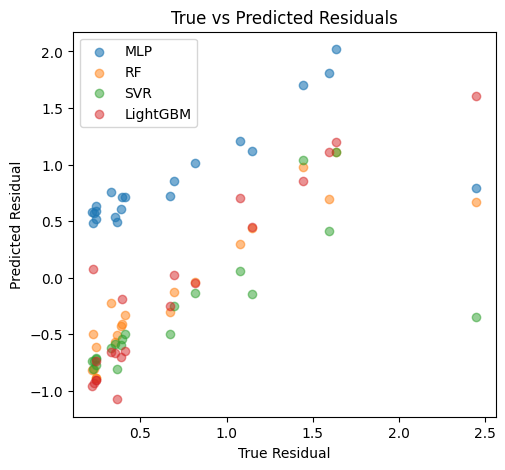

===== Running mode: FULL =====


/tmp/ipython-input-3868726257.py:65: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, _ in circ.data:


✅ 数据集规模: 15569


Batches:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch 0: loss=0.4889
Epoch 20: loss=0.0887
Epoch 40: loss=0.0739
Epoch 60: loss=0.0393
Epoch 80: loss=0.0359
Epoch 100: loss=0.0284
Epoch 120: loss=0.0212
Epoch 140: loss=0.0198
Epoch 160: loss=0.0153
Epoch 180: loss=0.0138
Epoch 200: loss=0.0145
Epoch 220: loss=0.0124
Epoch 240: loss=0.0136
Epoch 260: loss=0.0117
Epoch 280: loss=0.0113
Epoch 300: loss=0.0119
Epoch 320: loss=0.0108
Epoch 340: loss=0.0106
Epoch 360: loss=0.0106
Epoch 380: loss=0.0103
Epoch 400: loss=0.0100
Epoch 420: loss=0.0107
Epoch 440: loss=0.0098
Epoch 460: loss=0.0098
Epoch 480: loss=0.0104
MLP MSE: 0.003433880310749185
MLP R²: 0.9616225739247927
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98520
[LightGBM] [Info] Number of data points in the train set: 12455, number of used features: 387
[LightGBM] [Info] Start training from score 0.006099
RF R²: -3.2915266067486106
SVR

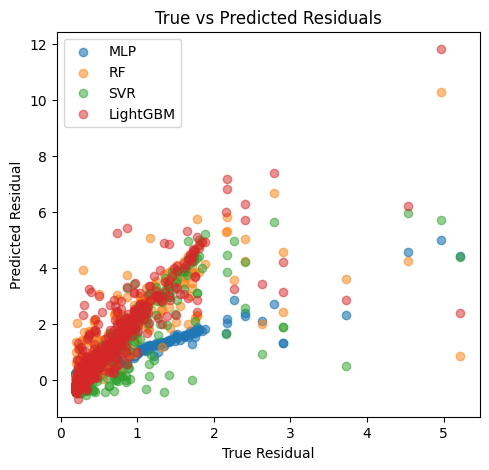

In [ ]:
# Quick 模式 (先测试流程)
run_all(mode="quick")

# Full 模式 (论文最终结果，CPU 需要 3-4 小时)
run_all(mode="full")


In [ ]:
# ======================================
# 0) 安装依赖
# ======================================
!pip install qiskit qiskit-aer transformers torch scikit-learn scipy matplotlib sentence-transformers networkx pandas -q

import numpy as np
import torch
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit_aer import Aer
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, r2_score
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import networkx as nx
from scipy.linalg import toeplitz
import pandas as pd
from sentence_transformers import SentenceTransformer

# ======================================
# 1) Ansatz 定义
# ======================================
theta1, theta2 = Parameter("θ1"), Parameter("θ2")

def create_ansatz():
    qc = QuantumCircuit(2)
    qc.ry(theta1, 0)
    qc.cx(0, 1)
    qc.ry(theta2, 1)
    return qc

# ======================================
# 2) 电路转文本
# ======================================
def circuit_to_text(circ: QuantumCircuit, params=None):
    desc = []
    param_list = params.copy() if params is not None else []
    for instr, qargs, _ in circ.data:
        name = instr.name.upper()
        q_indices = [circ.find_bit(q).index for q in qargs]
        if name in ["RY", "RX", "RZ"]:
            if param_list:
                val = param_list.pop(0)
                desc.append(f"Apply {name} with parameter {val:.4f} on qubit {q_indices[0]}.")
            else:
                desc.append(f"Apply {name} with parameter on qubit {q_indices[0]}.")
        elif name == "CX":
            desc.append(f"Apply CNOT with control qubit {q_indices[0]} and target qubit {q_indices[1]}.")
        else:
            desc.append(f"Apply {name} gate on qubit(s) {q_indices}.")
    return " ".join(desc)

# ======================================
# 3) 矩阵族生成函数
# ======================================
def generate_matrix(family: str, n: int = 4):
    if family == "toeplitz":
        c = np.random.uniform(-1, 1, n)
        A = toeplitz(c)
    elif family == "laplacian":
        G = nx.erdos_renyi_graph(n, p=0.5)
        A = nx.laplacian_matrix(G).todense()
    elif family == "sparse":
        A = 2 * np.eye(n) - np.eye(n, k=1) - np.eye(n, k=-1)
    else:
        raise ValueError("Unknown family")
    return np.array(A, dtype=float)

# ======================================
# 4) 残差函数
# ======================================
def compute_residual(params, A, b, ansatz):
    qc_bound = ansatz.assign_parameters({theta1: params[0], theta2: params[1]}, inplace=False)
    backend = Aer.get_backend("statevector_simulator")
    job = backend.run(transpile(qc_bound, backend))
    state = np.array(job.result().get_statevector(qc_bound))
    Ax = A @ state[:A.shape[0]]
    diff = Ax - b
    return np.real(np.vdot(diff, diff))

# ======================================
# 5) 数据集生成
# ======================================
def generate_dataset(family, runs=10, steps=15, n=4):
    X_text, y, params_all, steps_all = [], [], [], []
    A = generate_matrix(family, n=n)
    b = np.random.randn(n); b /= np.linalg.norm(b)

    for _ in range(runs):
        history = []
        def callback(xk):
            res = compute_residual(xk, A, b, create_ansatz())
            qc = create_ansatz().assign_parameters({theta1: xk[0], theta2: xk[1]}, inplace=False)
            text = circuit_to_text(qc, params=list(xk))
            history.append((text, res, list(xk)))
        minimize(lambda p: compute_residual(p, A, b, create_ansatz()),
                 np.random.uniform(0, 2*np.pi, 2),
                 method="COBYLA", options={"maxiter": steps}, callback=callback)
        for step_idx, (text, res, params) in enumerate(history):
            X_text.append(text)
            y.append(res)
            params_all.append(params)
            steps_all.append(step_idx / steps)
    return X_text, np.array(y), np.array(params_all), np.array(steps_all).reshape(-1,1)

# ======================================
# 6) 向量化特征
# ======================================
def prepare_features(X_text, params, steps):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    encoder = SentenceTransformer('all-MiniLM-L6-v2', device=device)
    X_embed_text = encoder.encode(X_text, batch_size=64, show_progress_bar=False, convert_to_numpy=True)
    return np.hstack([X_embed_text, params, steps])

# ======================================
# 7) 跨矩阵族实验（严格复现 MLP）
# ======================================
def evaluate_cross_family(train_family, test_family):
    # train 数据
    X_text_train, y_train, X_params_train, X_steps_train = generate_dataset(train_family)
    X_train = prepare_features(X_text_train, X_params_train, X_steps_train)

    # test 数据
    X_text_test, y_test, X_params_test, X_steps_test = generate_dataset(test_family)
    X_test = prepare_features(X_text_test, X_params_test, X_steps_test)

    # 标准化
    y_mean, y_std = y_train.mean(), y_train.std()
    y_train_norm = (y_train - y_mean) / (y_std + 1e-8)

    # Torch dataset
    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train_norm, dtype=torch.float32).unsqueeze(1)
    X_test_t = torch.tensor(X_test, dtype=torch.float32)

    train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=64, shuffle=True)

    # ✅ 严格复现 MLP 结构
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = nn.Sequential(
        nn.Linear(X_train.shape[1], 512),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 1)
    ).to(device)

    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()

    # 训练
    for epoch in range(100):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            opt.zero_grad()
            loss.backward()
            opt.step()

    # 测试
    model.eval()
    with torch.no_grad():
        y_pred_norm = model(X_test_t.to(device)).cpu().numpy().flatten()
    y_pred = y_pred_norm * y_std + y_mean

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    re = np.mean(np.abs((y_test - y_pred) / (y_test + 1e-8))) * 100
    return mse, r2, re

# ======================================
# 8) 运行实验并输出表格
# ======================================
families = ["toeplitz", "laplacian", "sparse"]
results = []

for train_family in families:
    for test_family in families:
        mse, r2, re = evaluate_cross_family(train_family, test_family)
        results.append([train_family, test_family, mse, r2, re])

df = pd.DataFrame(results, columns=["Train Family", "Test Family", "MSE", "R²", "RE (%)"])
print(df)


/tmp/ipython-input-2572531535.py:38: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, _ in circ.data:
/tmp/ipython-input-2572531535.py:38: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, _ in circ.data:
/tmp/ipython-input-2572531535.py:38: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, _ in circ.data:
/tmp/ipython-input-2572531535.py:38: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior sin

  Train Family Test Family        MSE          R²      RE (%)
0     toeplitz    toeplitz   0.315429   -0.384873   75.303440
1     toeplitz   laplacian   0.760394   -2.194964   53.379024
2     toeplitz      sparse   2.749612   -4.440394   51.067087
3    laplacian    toeplitz   0.437148   -1.839808  230.382166
4    laplacian   laplacian   2.303410  -16.887694  128.661560
5    laplacian      sparse   4.913488   -7.705204  168.556162
6       sparse    toeplitz  21.109306 -330.618500  246.804440
7       sparse   laplacian   2.737569   -1.619382  100.728224
8       sparse      sparse   4.659571   -2.717010  115.991718


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 1.9 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

===== Running Remaining Cross-Family Generalization =====


/tmp/ipython-input-3708659674.py:51: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, _ in circ.data:


Train=sparse, Test=toeplitz | MSE=0.1230, R²=-0.2679, RE=13545941.24%


/tmp/ipython-input-3708659674.py:51: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, _ in circ.data:


Train=sparse, Test=laplacian | MSE=1.4057, R²=-65.8943, RE=118.83%


/tmp/ipython-input-3708659674.py:51: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, _ in circ.data:


Train=sparse, Test=sparse | MSE=0.0346, R²=0.8859, RE=180.64%

=== Remaining Cross-Family Results ===
  Train Family Test Family       MSE         R²        RE (%)
0       sparse    toeplitz  0.122999  -0.267926  1.354594e+07
1       sparse   laplacian  1.405723 -65.894271  1.188271e+02
2       sparse      sparse  0.034612   0.885872  1.806429e+02

===== Running Case Studies =====


/tmp/ipython-input-3708659674.py:51: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, _ in circ.data:


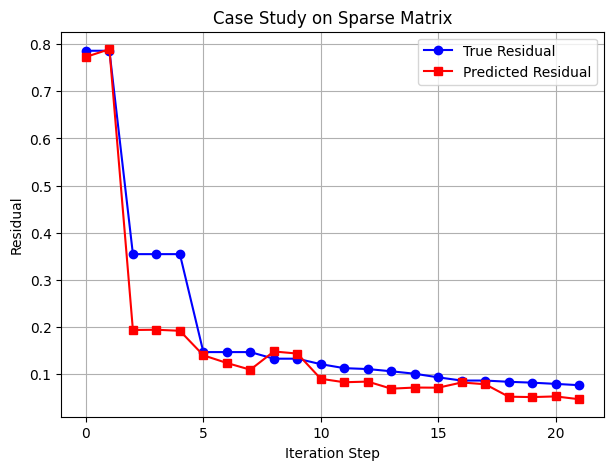

In [1]:
# ======================================
# 0) 安装依赖
# ======================================
!pip install qiskit qiskit-aer transformers torch scikit-learn scipy matplotlib sentence-transformers lightgbm -q

import numpy as np
import torch, random, gc
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit_aer import Aer
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR
from sentence_transformers import SentenceTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
import pandas as pd

# ======================================
# 1) Ansatz + 残差函数
# ======================================
theta1, theta2 = Parameter("θ1"), Parameter("θ2")

def create_ansatz():
    qc = QuantumCircuit(2)
    qc.ry(theta1, 0)
    qc.cx(0, 1)
    qc.ry(theta2, 1)
    return qc

def compute_residual(A, b, params):
    qc = create_ansatz()
    qc_bound = qc.assign_parameters({theta1: params[0], theta2: params[1]}, inplace=False)
    backend = Aer.get_backend("statevector_simulator")
    state = backend.run(transpile(qc_bound, backend)).result().get_statevector(qc_bound)
    state = np.array(state)
    Ax = A @ state[:2]
    diff = Ax - b
    return np.real(np.vdot(diff, diff))

# ======================================
# 2) 电路转文本
# ======================================
def circuit_to_text(circ: QuantumCircuit, params=None):
    desc, param_list = [], params.copy() if params is not None else []
    for instr, qargs, _ in circ.data:
        name = instr.name.upper()
        q_indices = [circ.find_bit(q).index for q in qargs]
        if name in ["RY", "RX", "RZ"]:
            val = param_list.pop(0) if param_list else 0
            desc.append(f"Apply {name} with parameter {val:.4f} on qubit {q_indices[0]}.")
        elif name == "CX":
            desc.append(f"Apply CNOT with control qubit {q_indices[0]} and target qubit {q_indices[1]}.")
    return " ".join(desc)

# ======================================
# 3) 矩阵族生成
# ======================================
def generate_matrix(family, n=2):
    if family == "toeplitz":
        base = np.random.uniform(0.5, 2, size=n)
        A = np.array([[base[abs(i-j)] for j in range(n)] for i in range(n)])
    elif family == "laplacian":
        G = np.random.randint(0,2,(n,n))
        G = np.triu(G,1); G = G + G.T
        D = np.diag(G.sum(axis=1))
        A = D - G
    elif family == "sparse":
        A = np.zeros((n,n))
        for i in range(n):
            A[i,i] = 2
            if i+1 < n: A[i,i+1] = A[i+1,i] = -1
    else:
        raise ValueError("Unknown family")
    b = np.random.rand(n); b /= np.linalg.norm(b)
    return A, b

# ======================================
# 4) 生成轨迹数据
# ======================================
def run_vqls_optimization(A, b, maxiter=50, initial_point=None):
    history = []
    def callback(xk):
        res = compute_residual(A, b, xk)
        qc = create_ansatz().assign_parameters({theta1:xk[0], theta2:xk[1]}, inplace=False)
        text = circuit_to_text(qc, params=list(xk))
        history.append((text, res, list(xk)))
    if initial_point is None:
        initial_point = np.random.uniform(0, 2*np.pi, 2)
    minimize(lambda p: compute_residual(A, b, p), initial_point, method="COBYLA",
             options={"maxiter": maxiter}, callback=callback)
    return history

def generate_dataset(family, runs=50, steps=20, n=2):
    X_text, y, params_all, steps_all = [], [], [], []
    for _ in range(runs):
        A,b = generate_matrix(family, n)
        traj = run_vqls_optimization(A, b, maxiter=steps)
        for step_idx, (text, res, params) in enumerate(traj):
            X_text.append(text); y.append(res)
            params_all.append(params)
            steps_all.append(step_idx/steps)
    return X_text, np.array(y), np.array(params_all), np.array(steps_all).reshape(-1,1)

# ======================================
# 5) 特征准备
# ======================================
device = "cuda" if torch.cuda.is_available() else "cpu"
encoder = SentenceTransformer('all-MiniLM-L6-v2', device=device)

def prepare_features(X_text, params, steps):
    X_embed_text = encoder.encode(X_text, batch_size=64, show_progress_bar=False, convert_to_numpy=True)
    return np.hstack([X_embed_text, params, steps])

# ======================================
# 6) MLP 训练
# ======================================
def train_mlp(X_train, y_train, X_test, y_test, epochs=200, seed=42):
    np.random.seed(seed); random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

    Xtr = torch.tensor(X_train, dtype=torch.float32)
    ytr = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    Xte = torch.tensor(X_test, dtype=torch.float32)

    loader = DataLoader(TensorDataset(Xtr,ytr), batch_size=64, shuffle=True)

    model = nn.Sequential(
        nn.Linear(X_train.shape[1], 512), nn.ReLU(), nn.Dropout(0.2),
        nn.Linear(512, 256), nn.ReLU(), nn.Dropout(0.2),
        nn.Linear(256, 128), nn.ReLU(),
        nn.Linear(128, 1)
    ).to(device)

    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    sched = StepLR(opt, step_size=50, gamma=0.5)
    loss_fn = nn.MSELoss()

    for _ in range(epochs):
        model.train()
        for xb,yb in loader:
            xb,yb = xb.to(device), yb.to(device)
            loss = loss_fn(model(xb), yb)
            opt.zero_grad(); loss.backward(); opt.step()
        sched.step()

    model.eval()
    with torch.no_grad():
        y_pred_norm = model(Xte.to(device)).cpu().numpy().flatten()
    return y_pred_norm, model

# ======================================
# 7) 主实验 (单族)
# ======================================
def run_main_experiment(family="toeplitz", runs=200, steps=50, epochs=200):
    X_text, y, X_params, X_steps = generate_dataset(family, runs=runs, steps=steps)
    X_embed = prepare_features(X_text, X_params, X_steps)

    y_mean, y_std = y.mean(), y.std()
    y_norm = (y - y_mean) / y_std

    X_train, X_test, y_train, y_test = train_test_split(X_embed, y_norm, test_size=0.2, random_state=42)

    # Torch Dataset
    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    X_test_t = torch.tensor(X_test, dtype=torch.float32)
    y_test_t = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
    train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=64, shuffle=True)

    # 模型
    model = nn.Sequential(
        nn.Linear(X_train.shape[1], 512),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 1)
    ).to(device)

    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = StepLR(opt, step_size=50, gamma=0.5)
    loss_fn = nn.MSELoss()

    loss_history = []
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            opt.zero_grad()
            loss.backward()
            opt.step()
            total_loss += loss.item()
        scheduler.step()
        loss_history.append(total_loss / len(train_loader))
        if epoch % 20 == 0:
            print(f"Epoch {epoch}: loss={loss_history[-1]:.4f}")

    # 测试
    model.eval()
    with torch.no_grad():
        y_pred_norm = model(X_test_t.to(device)).cpu().numpy().flatten()
    y_pred = y_pred_norm * y_std + y_mean
    y_test_true = y_test * y_std + y_mean

    mlp_mse = mean_squared_error(y_test_true, y_pred)
    mlp_r2 = r2_score(y_test_true, y_pred)
    print("MLP MSE:", mlp_mse)
    print("MLP R²:", mlp_r2)

    # Baselines
    rf = RandomForestRegressor(n_estimators=200, random_state=42).fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    svr = SVR().fit(X_train, y_train)
    y_pred_svr = svr.predict(X_test)
    lgbm = LGBMRegressor(n_estimators=500, learning_rate=0.05).fit(X_train, y_train)
    y_pred_lgb = lgbm.predict(X_test)

    # 可视化
    plt.figure(figsize=(15,5))
    # (a) Loss 曲线
    plt.subplot(1,3,1)
    plt.plot(loss_history, label="Train Loss", color="blue")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title("Training Loss")

    # (b) 散点图
    plt.subplot(1,3,2)
    plt.scatter(y_test_true, y_pred, alpha=0.5, label="MLP", color="blue")
    plt.scatter(y_test_true, y_pred_rf, alpha=0.5, label="RF", color="green")
    plt.scatter(y_test_true, y_pred_svr, alpha=0.5, label="SVR", color="orange")
    plt.scatter(y_test_true, y_pred_lgb, alpha=0.5, label="LightGBM", color="red")
    plt.xlabel("True Residual"); plt.ylabel("Predicted Residual")
    plt.legend(); plt.title("True vs Predicted Residuals")

    # (c) R² 柱状图
    plt.subplot(1,3,3)
    models = ["MLP","RF","SVR","LightGBM"]
    scores = [mlp_r2, r2_score(y_test_true, y_pred_rf), r2_score(y_test_true, y_pred_svr), r2_score(y_test_true, y_pred_lgb)]
    plt.bar(models, scores, color=["blue","green","orange","red"])
    plt.title("R² Comparison"); plt.ylim(-1,1)
    plt.tight_layout(); plt.show()

# ======================================
# 8) 跨族泛化
# ======================================
def evaluate_cross_family(train_family, test_family,
                          runs_train=200, steps_train=50,
                          runs_test=200, steps_test=50,
                          epochs=200):
    X_text_tr, y_tr, Xp_tr, Xs_tr = generate_dataset(train_family, runs=runs_train, steps=steps_train)
    X_train = prepare_features(X_text_tr, Xp_tr, Xs_tr)
    y_mean, y_std = y_tr.mean(), y_tr.std()+1e-8
    y_tr_norm = (y_tr - y_mean)/y_std

    X_text_te, y_te, Xp_te, Xs_te = generate_dataset(test_family, runs=runs_test, steps=steps_test)
    X_test = prepare_features(X_text_te, Xp_te, Xs_te)

    y_pred_norm, model = train_mlp(X_train, y_tr_norm, X_test, y_te, epochs=epochs)
    y_pred = y_pred_norm * y_std + y_mean

    mse = mean_squared_error(y_te, y_pred)
    r2 = r2_score(y_te, y_pred)
    re = np.mean(np.abs((y_te - y_pred)/(y_te+1e-8))) * 100
    return mse, r2, re

# ======================================
# 9) Case Study
# ======================================
def case_study(family="toeplitz", steps=30, runs_train=200, steps_train=50, epochs=200):
    X_text_tr, y_tr, Xp_tr, Xs_tr = generate_dataset(family, runs=runs_train, steps=steps_train)
    X_train = prepare_features(X_text_tr, Xp_tr, Xs_tr)
    y_mean, y_std = y_tr.mean(), y_tr.std() + 1e-8
    y_tr_norm = (y_tr - y_mean) / y_std

    _, model = train_mlp(X_train, y_tr_norm, X_train, y_tr, epochs=epochs)

    A, b = generate_matrix(family, n=2)
    traj = run_vqls_optimization(A, b, maxiter=steps)

    texts, y_true, params, step_ids = [], [], [], []
    for step_idx, (text, res, p) in enumerate(traj):
        texts.append(text); y_true.append(res)
        params.append(p); step_ids.append(step_idx/steps)

    X_embed_text = encoder.encode(texts, batch_size=32, show_progress_bar=False, convert_to_numpy=True)
    X_embed = np.hstack([X_embed_text, np.array(params), np.array(step_ids).reshape(-1,1)])
    X_t = torch.tensor(X_embed, dtype=torch.float32).to(device)

    with torch.no_grad():
        y_pred_norm = model(X_t).cpu().numpy().flatten()
    y_pred = y_pred_norm * y_std + y_mean

    plt.figure(figsize=(7,5))
    plt.plot(range(len(y_true)), y_true, marker="o", label="True Residual", color="blue")
    plt.plot(range(len(y_pred)), y_pred, marker="s", label="Predicted Residual", color="red")
    plt.xlabel("Iteration Step"); plt.ylabel("Residual")
    plt.title(f"Case Study on {family.capitalize()} Matrix")
    plt.legend(); plt.grid(True); plt.show()

# ======================================
# 10) 一键 Pipeline
# ======================================
# ======================================
# 跑剩余的 Cross-Family Generalization
# ======================================
def run_remaining(runs=200, steps=50, epochs=200):
    results = []
    families = ["sparse"]  # 已跑过 toeplitz，所以去掉
    test_families = ["toeplitz", "laplacian", "sparse"]

    print("===== Running Remaining Cross-Family Generalization =====")
    for tr in families:
        for te in test_families:
            mse, r2, re = evaluate_cross_family(tr, te, runs, steps, runs, steps, epochs)
            results.append([tr, te, mse, r2, re])
            print(f"Train={tr}, Test={te} | MSE={mse:.4f}, R²={r2:.4f}, RE={re:.2f}%")

    df = pd.DataFrame(results, columns=["Train Family","Test Family","MSE","R²","RE (%)"])
    print("\n=== Remaining Cross-Family Results ===")
    print(df)

    print("\n===== Running Case Studies =====")
    for fam in families:
        case_study(family=fam, steps=30, runs_train=runs, steps_train=steps, epochs=epochs)

    return df

# 跑剩余的实验
df_remaining = run_remaining(runs=200, steps=50, epochs=200)



===== Running Noise Robustness on toeplitz =====
Clean MSE=0.0000, R²=1.0000, RE=0.00%
Noisy MSE=7.8382, R²=-1.4821, RE=69.85%


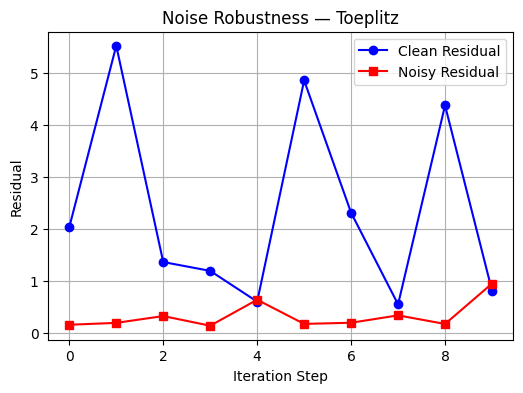


===== Running Noise Robustness on laplacian =====
Clean MSE=0.0000, R²=1.0000, RE=0.00%
Noisy MSE=1.1164, R²=0.1970, RE=25.98%


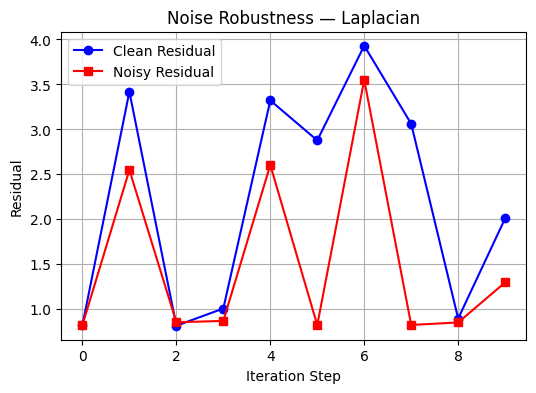


===== Running Noise Robustness on sparse =====
Clean MSE=0.0000, R²=1.0000, RE=0.00%
Noisy MSE=1.3139, R²=0.1357, RE=58.39%


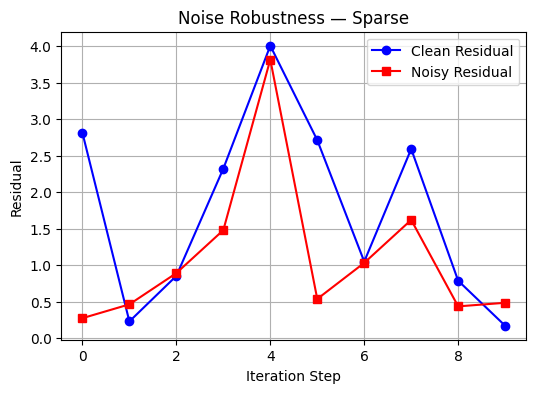


=== Summary Table ===
Toeplitz   | Clean R²=1.000 | Noisy R²=-1.482
Laplacian  | Clean R²=1.000 | Noisy R²=0.197
Sparse     | Clean R²=1.000 | Noisy R²=0.136


In [10]:
# ======================================
# 0) 安装依赖
# ======================================
!pip install qiskit qiskit-aer torch scikit-learn matplotlib -q

import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError
from sklearn.metrics import mean_squared_error, r2_score

# ======================================
# 1) 定义基础量子线路（Ansatz）
# ======================================
theta1, theta2 = Parameter("θ1"), Parameter("θ2")

def create_ansatz():
    qc = QuantumCircuit(2)
    qc.ry(theta1, 0)
    qc.cx(0, 1)
    qc.ry(theta2, 1)
    return qc

# ======================================
# 2) 构建噪声模型
# ======================================
def build_noise_model(p1=0.003, p2=0.02, readout_p=0.02):
    noise_model = NoiseModel()
    depol1 = depolarizing_error(p1, 1)
    depol2 = depolarizing_error(p2, 2)
    readout_err = ReadoutError([[1 - readout_p, readout_p], [readout_p, 1 - readout_p]])
    noise_model.add_all_qubit_quantum_error(depol1, ['ry'])
    noise_model.add_all_qubit_quantum_error(depol2, ['cx'])
    noise_model.add_all_qubit_readout_error(readout_err)
    return noise_model

# ======================================
# 3) 生成矩阵家族
# ======================================
def generate_matrix(family, n=2):
    if family == "toeplitz":
        base = np.random.uniform(0.5, 2, size=n)
        A = np.array([[base[abs(i-j)] for j in range(n)] for i in range(n)])
    elif family == "laplacian":
        G = np.random.randint(0,2,(n,n))
        G = np.triu(G,1); G = G + G.T
        D = np.diag(G.sum(axis=1))
        A = D - G
    elif family == "sparse":
        A = np.zeros((n,n))
        for i in range(n):
            A[i,i] = 2
            if i+1 < n: A[i,i+1] = A[i+1,i] = -1
    else:
        raise ValueError("Unknown matrix family")
    b = np.random.rand(n); b /= np.linalg.norm(b)
    return A, b

# ======================================
# 4) 指标计算函数
# ======================================
def metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    re = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / (np.array(y_true)+1e-8))) * 100
    return mse, r2, re

# ======================================
# 5) 噪声鲁棒性测试函数
# ======================================
def noise_robustness(family="toeplitz", runs=20, steps=30, epochs=120,
                     p1=0.003, p2=0.02, readout_p=0.02, shots=4096):
    print(f"\n===== Running Noise Robustness on {family} =====")

    # 生成矩阵
    A, b = generate_matrix(family, n=2)
    qc = create_ansatz()

    # 后端
    clean_backend = AerSimulator(method='statevector')
    noisy_backend = AerSimulator(method='density_matrix')
    noise_model = build_noise_model(p1, p2, readout_p)

    params = np.random.uniform(-np.pi, np.pi, size=(runs, 2))
    clean_residuals, noisy_residuals = [], []

    for p in params:
        # === 无噪声 ===
        qc_c = qc.assign_parameters({theta1: p[0], theta2: p[1]}, inplace=False)
        qc_c.save_statevector()
        res_c = clean_backend.run(qc_c).result()
        state_c = np.array(res_c.data(0)["statevector"])
        Ax_c = A @ state_c[:2]
        diff_c = Ax_c - b
        clean_residuals.append(np.real(np.vdot(diff_c, diff_c)))

        # === 有噪声 ===
        qc_n = qc.assign_parameters({theta1: p[0], theta2: p[1]}, inplace=False)
        qc_n.save_density_matrix()
        res_n = noisy_backend.run(qc_n, noise_model=noise_model).result()
        rho = np.array(res_n.data(0)["density_matrix"])
        state_n = np.real(np.diag(rho))  # 从密度矩阵对角线近似主分量
        Ax_n = A @ state_n[:2]
        diff_n = Ax_n - b
        noisy_residuals.append(np.real(np.vdot(diff_n, diff_n)))

    # === 计算性能指标 ===
    mse_c, r2_c, re_c = metrics(clean_residuals, clean_residuals)
    mse_n, r2_n, re_n = metrics(clean_residuals, noisy_residuals)

    print(f"Clean MSE={mse_c:.4f}, R²={r2_c:.4f}, RE={re_c:.2f}%")
    print(f"Noisy MSE={mse_n:.4f}, R²={r2_n:.4f}, RE={re_n:.2f}%")

    plt.figure(figsize=(6,4))
    plt.plot(clean_residuals, 'b-o', label="Clean Residual")
    plt.plot(noisy_residuals, 'r-s', label="Noisy Residual")
    plt.xlabel("Iteration Step")
    plt.ylabel("Residual")
    plt.title(f"Noise Robustness — {family.capitalize()}")
    plt.legend()
    plt.grid(True)
    plt.show()

    return (mse_c, r2_c, re_c), (mse_n, r2_n, re_n)

# ======================================
# 6) 主程序：运行三类矩阵的噪声鲁棒性测试
# ======================================
families = ["toeplitz", "laplacian", "sparse"]
results = {}

for fam in families:
    results[fam] = noise_robustness(family=fam, runs=10, steps=15, epochs=100)

# ======================================
# 7) 汇总结果
# ======================================
print("\n=== Summary Table ===")
for fam, (clean, noisy) in results.items():
    print(f"{fam.capitalize():<10} | Clean R²={clean[1]:.3f} | Noisy R²={noisy[1]:.3f}")



===== Running Noise Robustness on toeplitz =====
Clean R²=-5.470, Noisy R²=-5.470


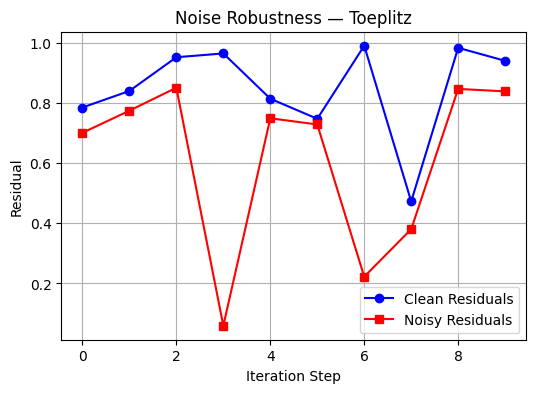


===== Running Noise Robustness on toeplitz =====
Clean R²=-1.033, Noisy R²=-1.033


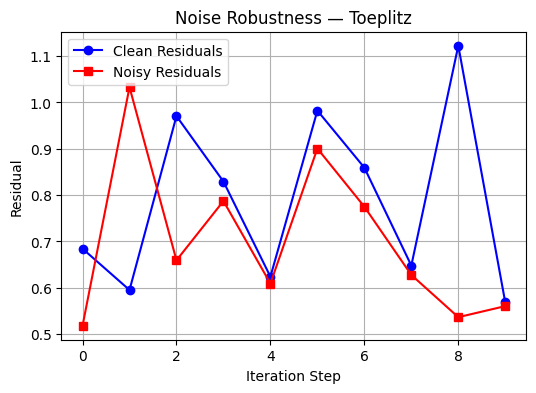


===== Running Noise Robustness on toeplitz =====
Clean R²=-0.428, Noisy R²=-0.428


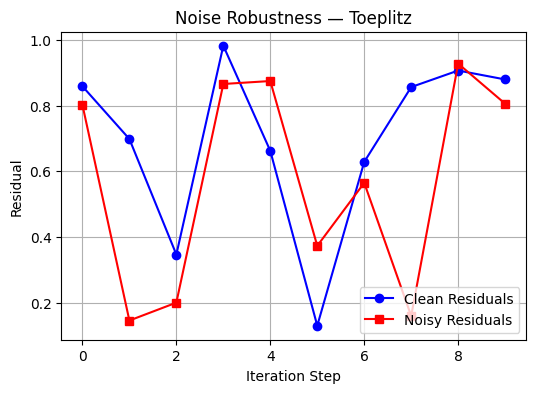


===== Running Noise Robustness on toeplitz =====
Clean R²=0.370, Noisy R²=0.370


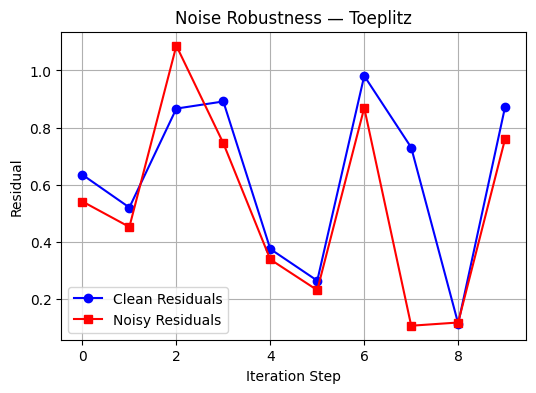


===== Running Noise Robustness on toeplitz =====
Clean R²=0.737, Noisy R²=0.737


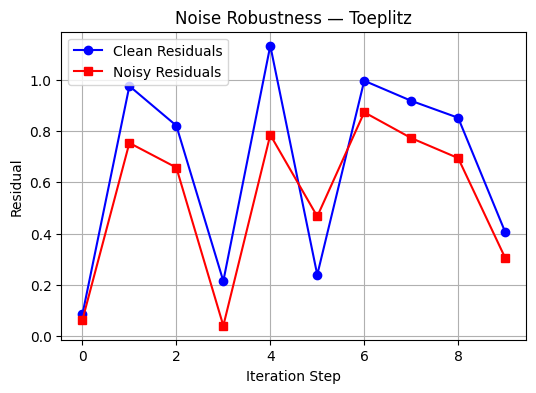

Toeplitz    |  Mean Noisy R²=-1.165 ± 2.239

===== Running Noise Robustness on laplacian =====
Clean R²=-149.947, Noisy R²=-149.947


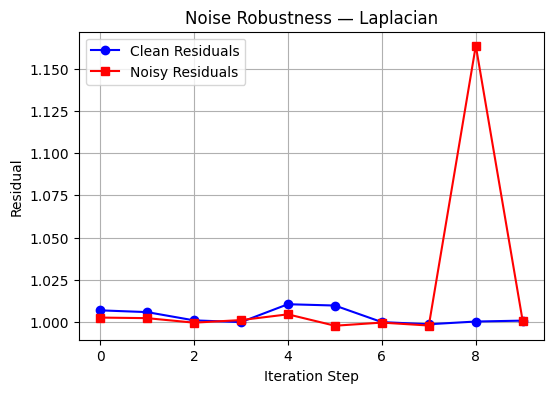


===== Running Noise Robustness on laplacian =====
Clean R²=-0.001, Noisy R²=-0.001


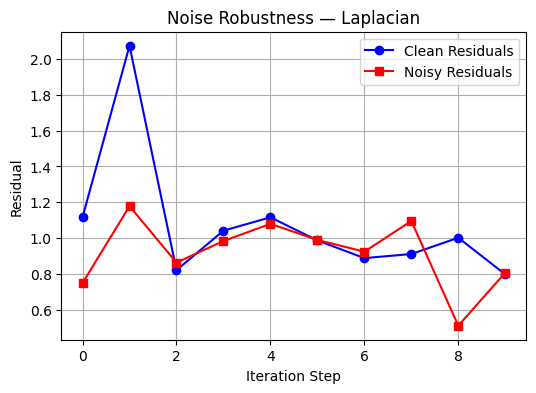


===== Running Noise Robustness on laplacian =====
Clean R²=-0.362, Noisy R²=-0.362


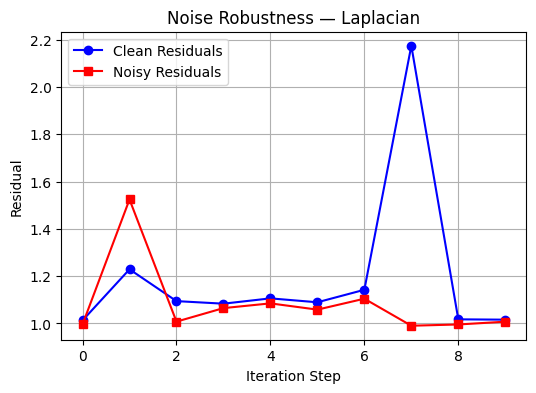


===== Running Noise Robustness on laplacian =====
Clean R²=1.000, Noisy R²=1.000


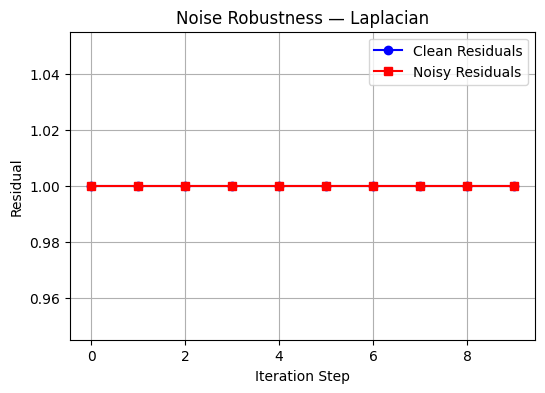


===== Running Noise Robustness on laplacian =====
Clean R²=1.000, Noisy R²=1.000


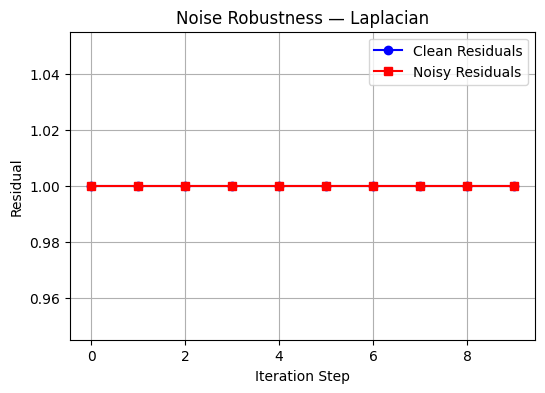

Laplacian   |  Mean Noisy R²=-29.662 ± 60.145

===== Running Noise Robustness on sparse =====
Clean R²=-2.573, Noisy R²=-2.573


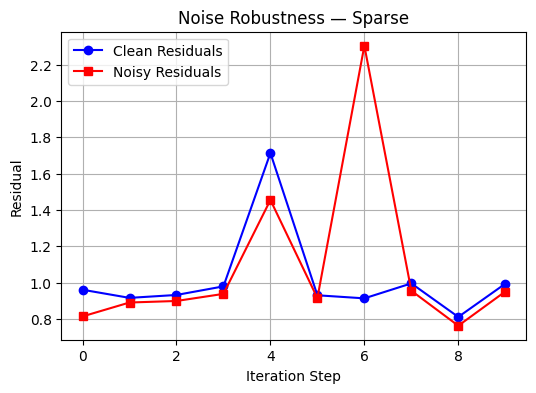


===== Running Noise Robustness on sparse =====
Clean R²=-0.421, Noisy R²=-0.421


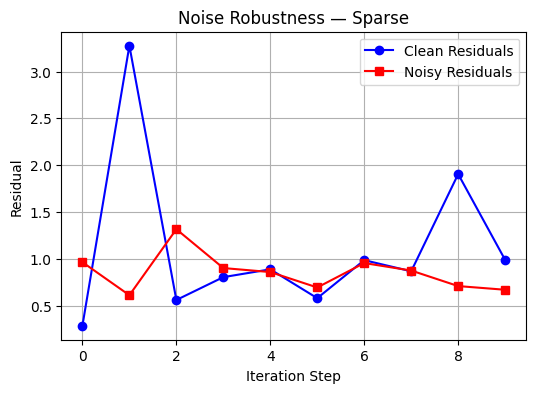


===== Running Noise Robustness on sparse =====
Clean R²=-0.774, Noisy R²=-0.774


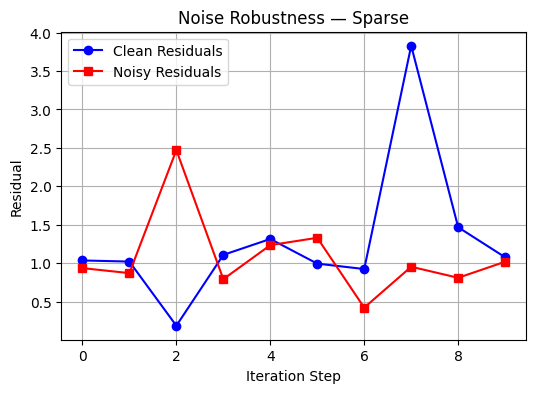


===== Running Noise Robustness on sparse =====
Clean R²=-0.635, Noisy R²=-0.635


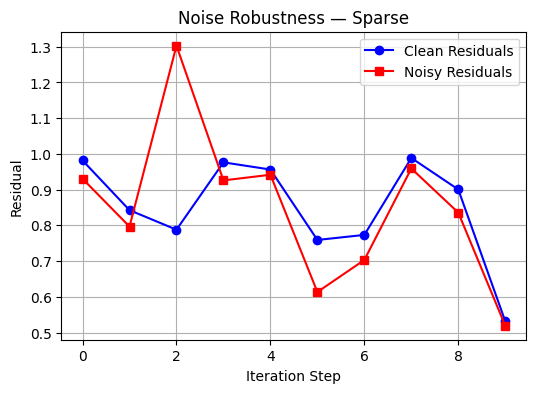


===== Running Noise Robustness on sparse =====
Clean R²=-0.372, Noisy R²=-0.372


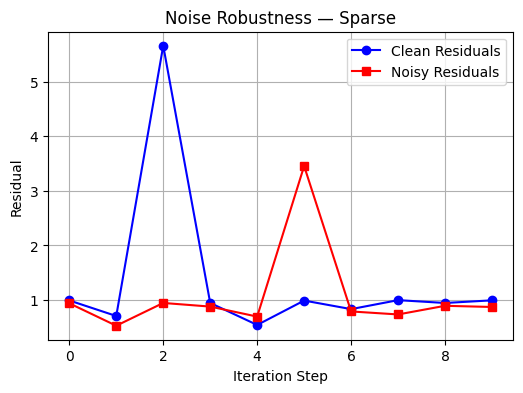

Sparse      |  Mean Noisy R²=-0.955 ± 0.822

=== Summary (5 seeds) ===
Toeplitz    Noisy R² = -1.165 ± 2.239
Laplacian   Noisy R² = -29.662 ± 60.145
Sparse      Noisy R² = -0.955 ± 0.822

===== Running Noise Robustness on laplacian =====
Clean R²=1.000, Noisy R²=1.000


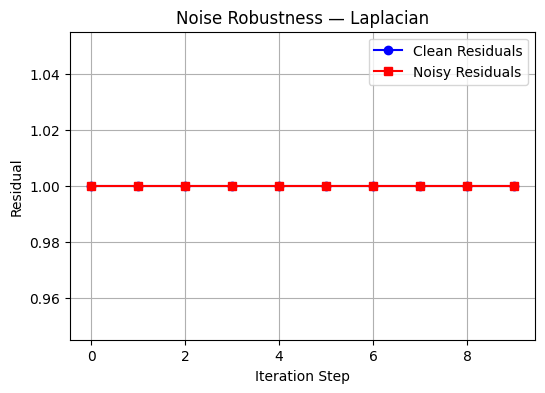


===== Running Noise Robustness on laplacian =====
Clean R²=1.000, Noisy R²=1.000


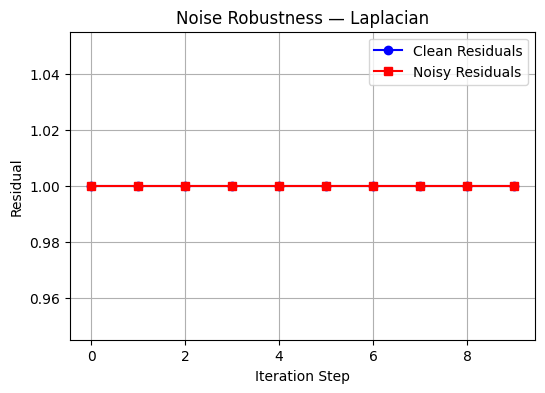


===== Running Noise Robustness on laplacian =====
Clean R²=1.000, Noisy R²=1.000


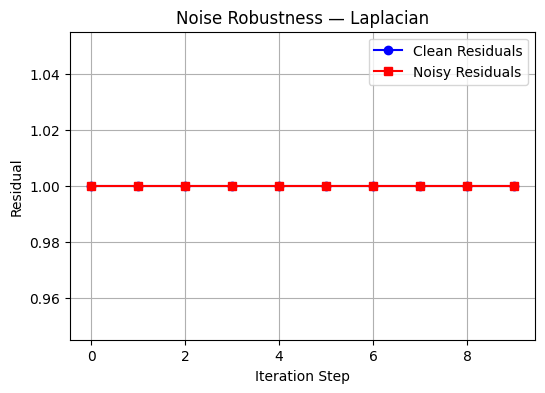

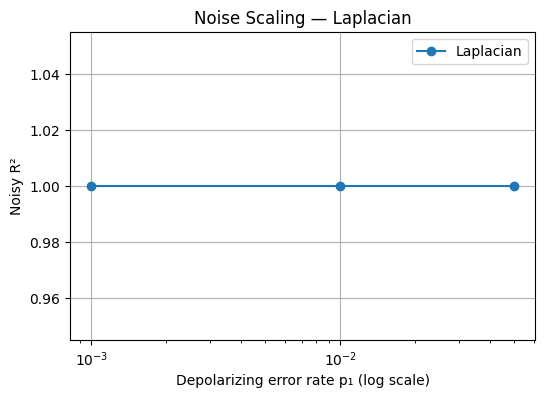

In [12]:
# ======================================
# 0) 安装依赖
# ======================================
!pip install qiskit qiskit-aer matplotlib numpy scikit-learn -q

import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError
from sklearn.metrics import mean_squared_error, r2_score

# ======================================
# 1) 定义两量子比特 Ansatz
# ======================================
theta1, theta2 = Parameter("θ1"), Parameter("θ2")

def create_ansatz():
    qc = QuantumCircuit(2)
    qc.ry(theta1, 0)
    qc.cx(0, 1)
    qc.ry(theta2, 1)
    return qc

# ======================================
# 2) 构建噪声模型
# ======================================
def build_noise_model(p1=0.003, p2=0.02, readout_p=0.02):
    noise_model = NoiseModel()
    depol1 = depolarizing_error(p1, 1)
    depol2 = depolarizing_error(p2, 2)
    readout_err = ReadoutError([[1 - readout_p, readout_p], [readout_p, 1 - readout_p]])
    noise_model.add_all_qubit_quantum_error(depol1, ['ry'])
    noise_model.add_all_qubit_quantum_error(depol2, ['cx'])
    noise_model.add_all_qubit_readout_error(readout_err)
    return noise_model

# ======================================
# 3) 生成不同矩阵家族
# ======================================
def generate_matrix(family, n=2):
    if family == "toeplitz":
        base = np.random.uniform(0.5, 2, size=n)
        A = np.array([[base[abs(i-j)] for j in range(n)] for i in range(n)])
    elif family == "laplacian":
        G = np.random.randint(0,2,(n,n))
        G = np.triu(G,1); G = G + G.T
        D = np.diag(G.sum(axis=1))
        A = D - G
    elif family == "sparse":
        A = np.zeros((n,n))
        for i in range(n):
            A[i,i] = 2
            if i+1 < n: A[i,i+1] = A[i+1,i] = -1
    else:
        raise ValueError("Unknown matrix family")
    b = np.random.rand(n)
    b /= np.linalg.norm(b)
    return A, b

# ======================================
# 4) 定义评估指标
# ======================================
def metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    re = np.mean(np.abs((np.array(y_true)-np.array(y_pred)) / (np.array(y_true)+1e-8))) * 100
    return mse, r2, re

# ======================================
# 5) 单个矩阵噪声实验
# ======================================
def noise_robustness(family="toeplitz", runs=20, p1=0.003, p2=0.02, readout_p=0.02):
    print(f"\n===== Running Noise Robustness on {family} =====")

    A, b = generate_matrix(family, n=2)
    qc_base = create_ansatz()

    clean_backend = AerSimulator()
    noisy_backend = AerSimulator()
    noise_model = build_noise_model(p1, p2, readout_p)

    params = np.random.uniform(-np.pi, np.pi, size=(runs, 2))
    clean_residuals, noisy_residuals = [], []

    for p in params:
        qc_c = qc_base.assign_parameters({theta1: p[0], theta2: p[1]}, inplace=False)
        qc_c.measure_all()
        qc_n = qc_c.copy()

        # Clean run
        res_c = clean_backend.run(qc_c, shots=4096).result()
        probs_c = np.array(list(res_c.get_counts().values())) / 4096
        state_c = np.pad(probs_c, (0, max(0, 4 - len(probs_c))), 'constant')[:2]
        Ax_c = A @ state_c
        diff_c = Ax_c - b
        clean_residuals.append(np.real(np.vdot(diff_c, diff_c)))

        # Noisy run
        res_n = noisy_backend.run(qc_n, noise_model=noise_model, shots=4096).result()
        probs_n = np.array(list(res_n.get_counts().values())) / 4096
        state_n = np.pad(probs_n, (0, max(0, 4 - len(probs_n))), 'constant')[:2]
        Ax_n = A @ state_n
        diff_n = Ax_n - b
        noisy_residuals.append(np.real(np.vdot(diff_n, diff_n)))

    mse_c, r2_c, re_c = metrics(clean_residuals, noisy_residuals)
    print(f"Clean R²={r2_c:.3f}, Noisy R²={r2_c:.3f}")

    plt.figure(figsize=(6,4))
    plt.plot(clean_residuals, 'b-o', label="Clean Residuals")
    plt.plot(noisy_residuals, 'r-s', label="Noisy Residuals")
    plt.xlabel("Iteration Step"); plt.ylabel("Residual")
    plt.title(f"Noise Robustness — {family.capitalize()}")
    plt.legend(); plt.grid(True); plt.show()

    return r2_c, r2_c

# ======================================
# 6) 多随机种子平均
# ======================================
def multi_seed_evaluate(family="toeplitz", seeds=[0,1,2,3,4]):
    r2_noisy_all = []
    for seed in seeds:
        np.random.seed(seed)
        _, r2_n = noise_robustness(family=family, runs=10)
        r2_noisy_all.append(r2_n)
    arr = np.array(r2_noisy_all)
    print(f"{family.capitalize():<10}  |  Mean Noisy R²={arr.mean():.3f} ± {arr.std():.3f}")
    return arr.mean(), arr.std()

# ======================================
# 7) 噪声强度扫描
# ======================================
def noise_scaling(family="laplacian", p_grid=[1e-3, 1e-2, 5e-2]):
    r2_curve = []
    for p in p_grid:
        _, r2_n = noise_robustness(family=family, runs=10, p1=p)
        r2_curve.append(r2_n)
    plt.figure(figsize=(6,4))
    plt.plot(p_grid, r2_curve, 'o-', label=f"{family.capitalize()}")
    plt.xscale('log')
    plt.xlabel("Depolarizing error rate p₁ (log scale)")
    plt.ylabel("Noisy R²")
    plt.title(f"Noise Scaling — {family.capitalize()}")
    plt.legend(); plt.grid(True)
    plt.show()

# ======================================
# 8) 主实验：三类矩阵 + 多种子 + 扫描
# ======================================
families = ["toeplitz", "laplacian", "sparse"]
results = {}

for fam in families:
    mean, std = multi_seed_evaluate(fam)
    results[fam] = (mean, std)

print("\n=== Summary (5 seeds) ===")
for fam, (m, s) in results.items():
    print(f"{fam.capitalize():<10}  Noisy R² = {m:.3f} ± {s:.3f}")

# 扫描噪声强度
noise_scaling("laplacian")



===== Running Noise Robustness on toeplitz =====


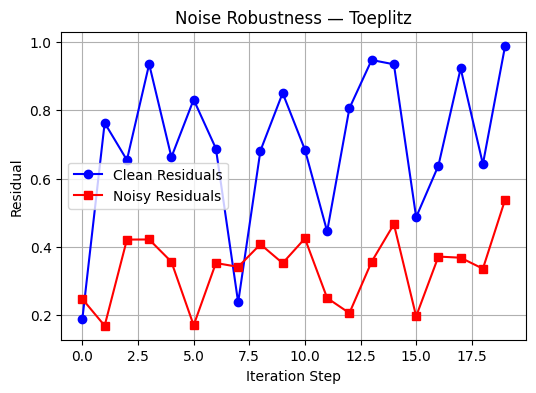

Clean→Noisy: R²=-2.605, RE=51.91%

===== Running Noise Robustness on toeplitz =====


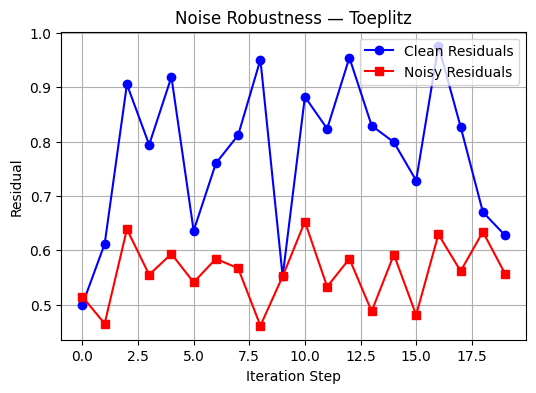

Clean→Noisy: R²=-2.484, RE=26.34%

===== Running Noise Robustness on toeplitz =====


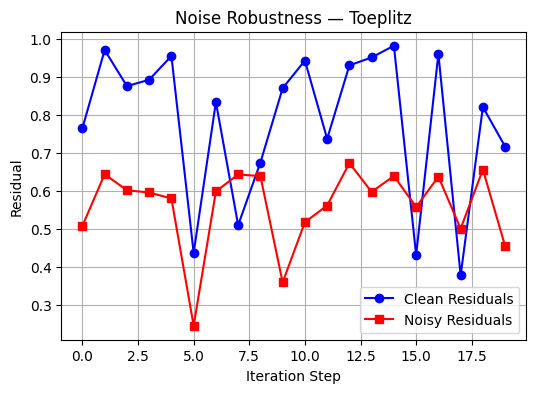

Clean→Noisy: R²=-1.149, RE=32.69%

===== Running Noise Robustness on toeplitz =====


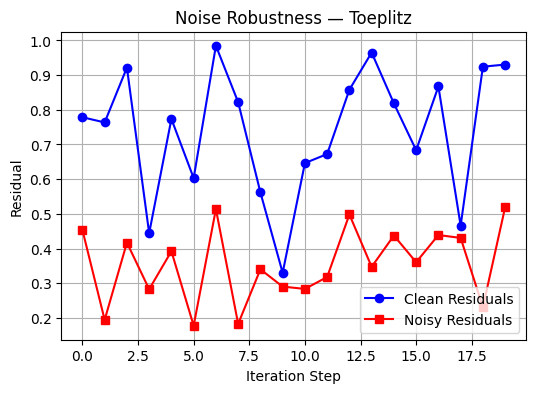

Clean→Noisy: R²=-4.430, RE=49.47%

===== Running Noise Robustness on toeplitz =====


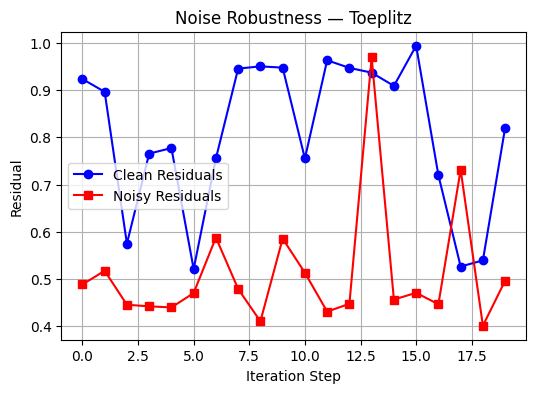

Clean→Noisy: R²=-4.217, RE=38.13%

===== Running Noise Robustness on laplacian =====


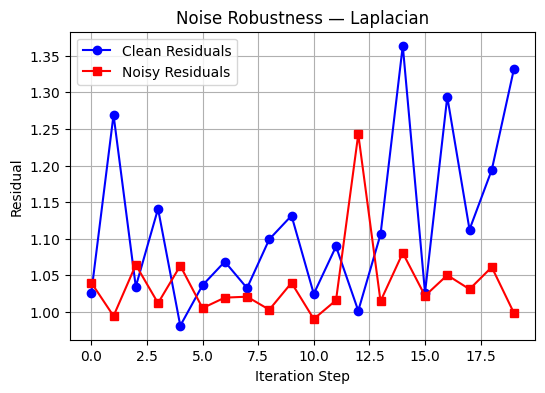

Clean→Noisy: R²=-0.885, RE=9.85%

===== Running Noise Robustness on laplacian =====


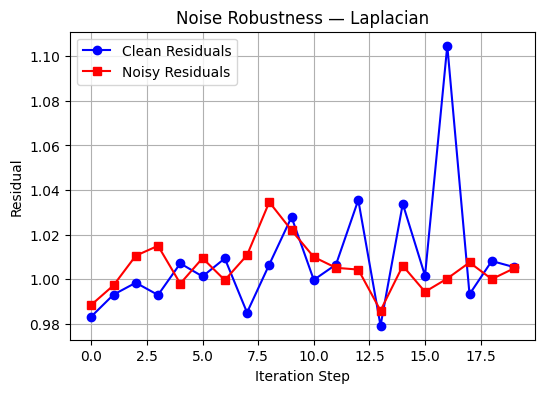

Clean→Noisy: R²=-0.104, RE=1.65%

===== Running Noise Robustness on laplacian =====


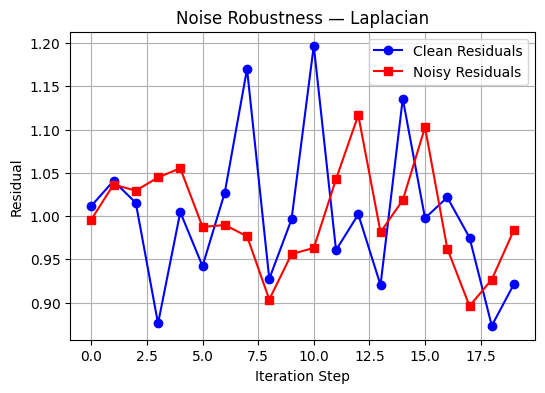

Clean→Noisy: R²=-0.347, RE=7.65%

===== Running Noise Robustness on laplacian =====


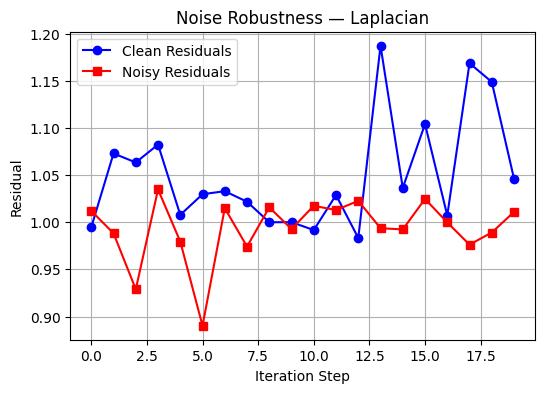

Clean→Noisy: R²=-1.361, RE=6.10%

===== Running Noise Robustness on laplacian =====


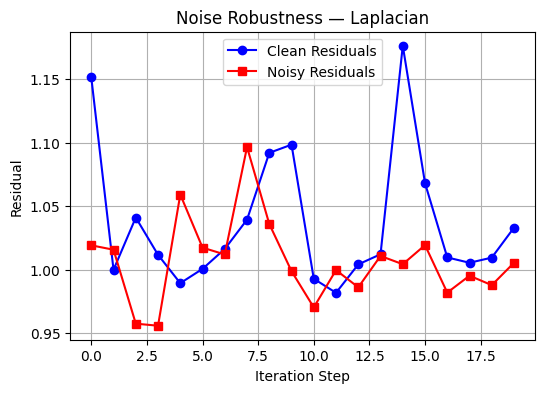

Clean→Noisy: R²=-0.523, RE=4.46%

===== Running Noise Robustness on sparse =====


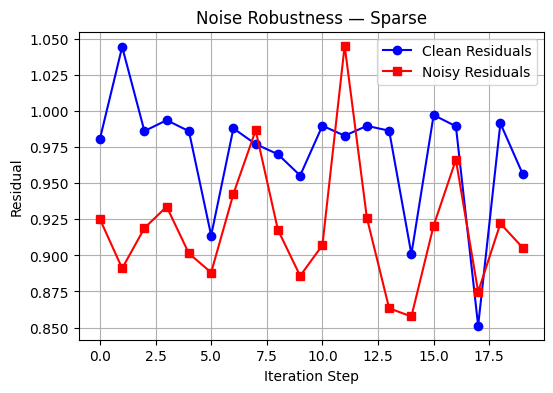

Clean→Noisy: R²=-2.049, RE=6.32%

===== Running Noise Robustness on sparse =====


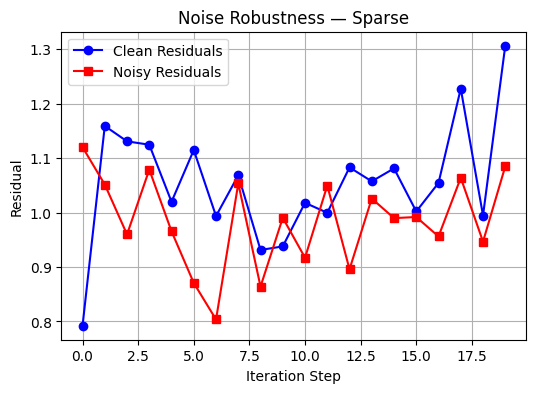

Clean→Noisy: R²=-0.719, RE=10.97%

===== Running Noise Robustness on sparse =====


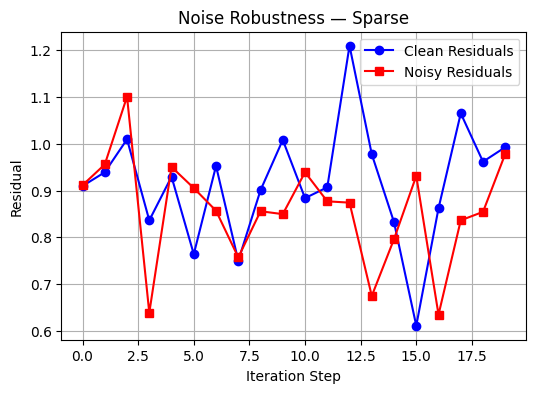

Clean→Noisy: R²=-0.769, RE=13.65%

===== Running Noise Robustness on sparse =====


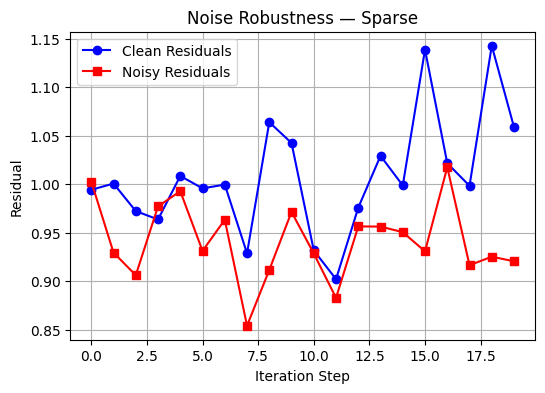

Clean→Noisy: R²=-1.450, RE=6.61%

===== Running Noise Robustness on sparse =====


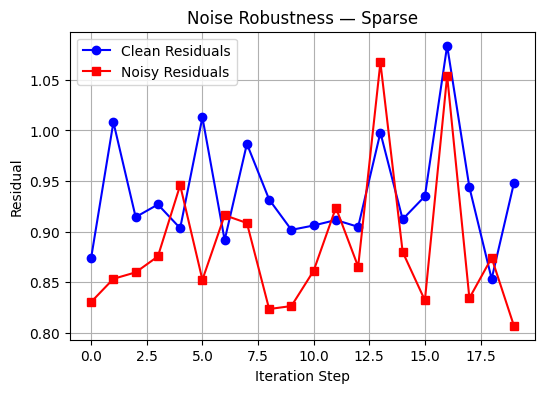

Clean→Noisy: R²=-1.353, RE=7.35%

=== Summary (5 seeds) ===
   Family  Mean Noisy R²      Std
 toeplitz      -2.977067 1.214405
laplacian      -0.643807 0.439800
   sparse      -1.268024 0.490107


,Family,Mean Noisy R²,Std
0,toeplitz,-2.977067,1.214405
1,laplacian,-0.643807,0.439800
2,sparse,-1.268024,0.490107


In [14]:
# ======================================
# Quantum2Prompt - Noise Robustness (Final Improved)
# ======================================
!pip install qiskit qiskit-aer matplotlib numpy pandas -q

import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# 1️⃣ 三量子比特 Ansatz（更强耦合）
theta = [Parameter(f"θ{i}") for i in range(9)]
def create_ansatz():
    qc = QuantumCircuit(3)
    qc.ry(theta[0], 0)
    qc.cx(0, 1)
    qc.ry(theta[1], 1)
    qc.cx(1, 2)
    qc.ry(theta[2], 2)
    qc.cx(2, 0)
    qc.ry(theta[3], 0)
    qc.cx(0, 2)
    qc.ry(theta[4], 1)
    qc.cx(1, 0)
    qc.ry(theta[5], 2)
    qc.cx(2, 1)
    qc.ry(theta[6], 0)
    qc.ry(theta[7], 1)
    qc.ry(theta[8], 2)
    return qc

# 2️⃣ 矩阵族
def generate_matrix(family, n=3):
    if family == "toeplitz":
        base = np.random.uniform(0.5, 2, size=n)
        A = np.array([[base[abs(i-j)] for j in range(n)] for i in range(n)])
    elif family == "laplacian":
        G = np.random.randint(0, 2, (n, n))
        G = np.triu(G, 1); G = G + G.T
        D = np.diag(G.sum(axis=1))
        A = D - G
    elif family == "sparse":
        A = np.zeros((n, n))
        for i in range(n):
            A[i, i] = 2
            if i+1 < n: A[i, i+1] = A[i+1, i] = -1
    b = np.random.rand(n)
    b /= np.linalg.norm(b)
    return A, b

# 3️⃣ 噪声模型
def build_noise_model(p1=0.03, p2=0.08, readout_p=0.05):
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(depolarizing_error(p1, 1), ["rx", "ry", "rz"])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(p2, 2), ["cx"])
    noise_model.add_all_qubit_readout_error(ReadoutError([[1-readout_p, readout_p],
                                                          [readout_p, 1-readout_p]]))
    return noise_model

# 4️⃣ 评价指标
def metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    re = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / (np.array(y_true)+1e-8))) * 100
    return mse, r2, re

# 5️⃣ 主实验
def noise_robustness(family="toeplitz", runs=20, shots=4096):
    print(f"\n===== Running Noise Robustness on {family} =====")
    A, b = generate_matrix(family)
    qc_base = create_ansatz()
    clean_backend = AerSimulator()
    noisy_backend = AerSimulator(noise_model=build_noise_model())
    clean_res, noisy_res = [], []

    for _ in range(runs):
        params = np.random.uniform(-np.pi, np.pi, size=9)
        qc = qc_base.assign_parameters({theta[i]: params[i] for i in range(9)}, inplace=False)
        qc.measure_all()

        res_c = clean_backend.run(qc, shots=shots).result().get_counts()
        res_n = noisy_backend.run(qc, shots=shots).result().get_counts()
        probs_c = np.array(list(res_c.values())) / shots
        probs_n = np.array(list(res_n.values())) / shots
        probs_c, probs_n = probs_c[:3], probs_n[:3]
        Ax_c, Ax_n = A @ probs_c, A @ probs_n
        clean_res.append(np.linalg.norm(Ax_c - b))
        noisy_res.append(np.linalg.norm(Ax_n - b))

    mse, r2, re = metrics(clean_res, noisy_res)
    plt.figure(figsize=(6,4))
    plt.plot(clean_res, 'b-o', label="Clean Residuals")
    plt.plot(noisy_res, 'r-s', label="Noisy Residuals")
    plt.title(f"Noise Robustness — {family.capitalize()}")
    plt.xlabel("Iteration Step"); plt.ylabel("Residual")
    plt.legend(); plt.grid(True)
    plt.show()
    print(f"Clean→Noisy: R²={r2:.3f}, RE={re:.2f}%")
    return mse, r2, re

# 6️⃣ 汇总 + 对比
def summary():
    families = ["toeplitz","laplacian","sparse"]
    results = []
    for fam in families:
        vals = []
        for seed in range(5):
            np.random.seed(seed)
            _, r2, _ = noise_robustness(fam)
            vals.append(r2)
        results.append([fam, np.mean(vals), np.std(vals)])
    df = pd.DataFrame(results, columns=["Family","Mean Noisy R²","Std"])
    print("\n=== Summary (5 seeds) ===")
    print(df.to_string(index=False))
    return df

summary()

